## **Ομάδα 4**

Ανθοπούλου Φαίδρα Αναστασία 03118818 

Θοδωρής Αράπης 03118028

Μέξης Θεόδωρος-Άγγελος 03118408

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [2]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [3]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 4

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [4]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Kabooliwala']
['"Romance Film",  "Drama",  "Comedy"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [5]:
# Αρχικά τυπώνουμε 10 διαφορετικές περιγραφές ταινιών για να εξετάσουμε τα corpus τους

for i in range(0,10):
  print(corpus[i])
  print("")

# Μπορούμε να αλλάξουμε τα όρια στο range ανά πάσα στιγμή, έτσι ώστε να εξετάσουμε ένα διαφορετικό σύνολο περιγραφών

Ambrose Wolfinger works as a "memory expert" for a manufacturing company's president; he keeps files of details about all the people President Malloy meets with, so that Malloy will never be embarrassed about not remembering things when meeting with them. Ambrose supports himself, his shrewish wife Leona, his loving daughter Hope , his freeloading brother-in-law Claude, and his abusive mother-in-law Cordelia. At the start of the film, two burglars break into Ambrose's cellar late at night, get drunk on his homemade applejack, and start singing "On the Banks of the Wabash"; Ambrose is forced to handle the situation, and he winds up being arrested for distilling liquor without a license. The next day, Ambrose  tells Malloy that Cordelia had died from drinking poisoned liquor, and asks for the afternoon off to attend the funeral; in fact, he wants to go to see the big wrestling match. Malloy, touched by Ambrose's tale, lets him go for the day, and Ambrose's immediate supervisor, Mr. Peabo

In [6]:
!pip install --upgrade contractions

In [7]:
# Ξεκινάμε την προεπεξεργασία
import nltk
import urllib
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('rslp')
from nltk.stem import WordNetLemmatizer
import re
import contractions

# Λέξεις που εμφανίζονται συχνά στις περιγραφές ταινιών και επομένως δυσχεραίνουν την ορθή λειτουργία του recommender
common_descWords = ("movie", "plot", "protagonist", "film", "story", "finale", "summary", "'s")

wordnet_lemmatizer = WordNetLemmatizer()
punctuations = list(string.punctuation)
st = set(stopwords.words("english"))

def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in punctuations)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

def get_names(url):
    decoded_url = urllib.request.urlopen(url).read().decode()
    name_list = decoded_url.split('\n')
    
    names = []
    for name in name_list:
        if name and name[0] != '#': # αγνοούμε τις πρώτες γραμμές που ξεκινάνε με 'δίεαση'
            names.append(name.lower())
    return set(names)

male_names = get_names("http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt")
female_names = get_names("http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt")

st = st.union(st, common_descWords)
st = st.union(st, male_names)
st = st.union(st, female_names)

for i in range(0,len(corpus)):
  corpus[i] = corpus[i].lower()  #μετατροπή των χαρακτήρων σε πεζά
  corpus[i] = re.sub(r"http\S+", " ", corpus[i])   #αφαιρούμε τα url links
  corpus[i] = contractions.fix(corpus[i])  #αφαιρούμε τις συντομογραφίες don't -> do not, you're -> you are
  tok = word_tokenize(corpus[i])
  tok = [i for i in tok if i not in punctuations] #αφαίρεση των ειδικών χαρακτήρων και της στίξης
  tok = thorough_filter(tok) #δεύτερο φιλτράρισμα για την περίπτωση που μια λέξη περιέχει punctuation
  tok = [word for word in tok if len(word)>2] #αφαίρεση των λέξεων με λιγότερους από 2 χαρακτήρες
  tok = [word for word in tok if not word in st] #αφαίρεση των stopwords, των ονομάτων, και των κοινών λέξεων
  corpus[i] = " ".join(wordnet_lemmatizer.lemmatize(word) for word in tok) #εφαρμόζουμε lemmatization

# Ελέγχουμε ότι δούλεψε
for i in range(0,10):
  print(corpus[i])
  print("")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /usr/share/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


wolfinger work memory expert manufacturing company president keep file detail people president malloy meet malloy never embarrassed remembering thing meeting support shrewish wife loving daughter freeloading brother-in-law abusive mother-in-law start two burglar break cellar late night get drunk homemade applejack start singing bank wabash forced handle situation wind arrested distilling liquor without license next day tell malloy died drinking poisoned liquor asks afternoon attend funeral fact want big wrestling match malloy touched tale let day immediate supervisor mr. peabody tell employee tragic news pay respect family throughout day one problem another encounter ticket-writing policeman car parked close find chasing tire along railroad track narrowly avoids getting hit train trying get wrestling arena get knocked wrestler thrown building opponent later day come home find furious seeing obituary newspaper receiving huge amount flower sympathy card funeral wreath furthermore peabody

Στην προεπεξεργασία εκτελέσαμε όλα τα βήματα που προτείνονται στην εκφώνηση (μετατροπή όλων των χαρακτήρων σε πεζά γιατί ο αλγόριθμος που συγκρίνει τις λέξεις μεταξύ τους είναι case sensitive, και αφαίρεση stopwords, πολύ μικρών συμβολοσειρών, σημείων στίξεως, και ειδικών χαρακτήρων καθώς δεν περιέχουν κάποια ουσιαστική πληροφρορία για την πλοκή μιας ταινίας αλλά η συχνότητα εμφάνισής τους μπορεί να επηρεάσει την μετρική tf-idf). Για τον δεύτερο από τους δύο λόγους που μόλις αναφέραμε, επιλέξαμε επίσης να αφαιρέσουμε όσα πιο πολλά ονόματα χαρακτήρων μπορούσαμε, καθώς και κάποιες λέξεις όπως "movie", "plot", κτλ οι οποίες εμφανίζονται συχνά σε περιγραφές ταινιών αλλά δεν έχουν άμεση σχέση με την πλοκή. Υπήρξε σκέψη και για αφαίρεση των αριθμών, αλλά αποφασίσαμε να μην το κάνουμε, καθώς κάποιοι αριθμοί θα ήταν και ημερομηνίες σχετικές με την υπόθεση (πχ δυό ταινίες που διαδραματίζονται την ίδια χρονική περίοδο). 

Επιπλέον, επιλέγουμε να εφαρμόσουμε την μέθοδο lemmatization αντί της stemming, καθώς αυτή ενδέχεται να εμφανίσει προβλήματα στην αναπαράσταση με word embeddings.

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf_plain = vectorizer.transform(corpus).toarray()

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [9]:
print(corpus_tf_idf_plain.shape)

(5000, 41528)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [10]:
from numpy.linalg import norm
import scipy as sp

def content_recommender(target_movie, max_recommendations, corpus_type):
  #tar_list = [corpus[target_movie]]
  #vectorizer.fit(tar_list)
  #target_tfidf = vectorizer.transform(tar_list)
  cossim = []
  for i in range(len(corpus_type)):
    #np.reshape(corp_tfidf[target_movie], corp_tfidf[i].shape)
    #cossim[i] = np.dot(target_tfidf[0],corp_tfidf[i])/(LA.norm(target_tfidf[0])*LA.norm(corp_tfidf[i])) #υπολογισμός ομοιότητας συνημιτόνου
    #sp_dst = sp.spatial.distance.cosine((corpus_type[target_movie], corpus_type[i])
    cossim.append(np.dot(corpus_type[target_movie],corpus_type[i])/(norm(corpus_type[target_movie])*norm(corpus_type[i])))
  sorted = np.argsort(cossim)[::-1]
  print("Target movie ID:",target_movie)
  print("Target movie title:",titles[target_movie])
  print("Target movie description:",corpus[target_movie])
  print("Target movie categories:",categories[target_movie])
  for i in range(1, max_recommendations + 1):
    mov_id = sorted[i]
    print("Σειρά σύστασης:", i)
    print("Ομοιότητα συνημιτόνου:",cossim[mov_id])
    print("Recommendation movie ID:",mov_id)
    print("Recommendation movie title:",titles[mov_id])
    print("Recommendation movie description:",corpus[mov_id])
    print("Recommendation movie categories:",categories[mov_id])

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




### **Test 1**

In [11]:
content_recommender(1,3,corpus_tf_idf_plain)

Target movie ID: 1
Target movie title: ['A Prize of Arms']
Target movie description: three criminal hatched plan army barrack troop dispatched take part war middle east believed large amount pay premise shipped gang enters army barrack disguised soldier proceeds pay corp headquarters guise maintenance work make sure alarm disabled give time make escape robbery take place rest day try integrate working base including vaccinated overseas service avoid attracting attention night fall change military police uniform head pay headquarters announcing arrival report fire begin searching room starting small blaze order premise evacuated building empty break safe steal £100,000 starting several fire cover activity withdraw carrying fake casualty stretcher troop rush across base put fire men drive secluded spot base left army truck officer ring medic check progress casualty told nobody arrived suspicious raise alarm whole camp put standby police sent initially fooled thinking criminal already lef

Για αυτήν την περίπτωση, η 2η σε σειρά σύσταση είναι καλή γιατί είναι και αυτή δραματική και περιέχει βία. Η 3η όμως σύσταση δεν είναι σχετική, καθώς είναι ένα ρομαντικό musical, όπως και η 2η που είναι ταινία φαντασίας κινουμένων σχεδίων προσανατολισμένη προς τα παιδία. 

### **Test 2**

In [12]:
content_recommender(10,3,corpus_tf_idf_plain)

Target movie ID: 10
Target movie title: ['Rabbit Transit']
Target movie description: relaxing steam bath bug read original fable reading credit tortoise beat hare becomes incensed idea turtle outrunning rabbit also steam bath claim could outrun bug prompting bug challenge race time bug agree cheating however quickly reveals rocket propelled allowing surprising combination fast slow bug best steal dismantle destroy device little effect end however bug manage top turtle cross finish line first nevertheless last laugh rook rabbit confessing 100 easy —in speed zone bug taken away police enjoy victory—behind bar close cartoon famously saying stinker
Target movie categories: ['"Short Film",  "Comedy film",  "Family Film",  "Animation"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.5465488737298734
Recommendation movie ID: 2862
Recommendation movie title: ['Forward March Hare']
Recommendation movie description: mailman delivered letter truck pull exhaust tailpipe cause letter drift mailbox acci

Σε αυτήν την περίπτωση και οι 3 συστάσεις είναι πάρα πολύ καλές, αφού είναι όλες ταινίες με τον Bugs Bunny όπως και η ταινία στόχος, και φυσικά ανήκουν σε όλα τα ίδια genres. 

### **Test 3**

In [13]:
content_recommender(30,6,corpus_tf_idf_plain)

Target movie ID: 30
Target movie title: ['Cover Story']
Target movie description: khan tabu next door neighbour chandrashekar retired judge haunted past two become friend computer engineer wear high power contact lens vision problem meet news reporter executive director true vision chandrashekar killed mysterious man seen recognised wearing contact lens time corrupt policeman think killer eventually discovers actually killer also killed chandashekar search real killer police attempting catch form rest
Target movie categories: ['"Thriller",  "Crime Fiction",  "World cinema",  "Drama",  "Romantic drama",  "Crime Thriller",  "Romance Film"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.15012394583003247
Recommendation movie ID: 3711
Recommendation movie title: ['Angry Guest']
Recommendation movie description: wenlie back time powerful japanese crime syndicate killer head villain duel fist escaped prison want retribution killer revenge lead wenlie girlfriend kidnapping force two hero travel 

Εδώ οι συστάσεις είναι ικανοποιητικές, καθώς σχεδόν όλες είναι σχετικές με εγκλήματα και περιέχουν βία όπως η ταινία στόχος. 

### **Test 4**

In [14]:
content_recommender(300,5,corpus_tf_idf_plain)

Target movie ID: 300
Target movie title: ['A Bittersweet Life']
Target movie description: sun-woo high ranking mobster enforcer kang cold calculating crime bos unquestionably loyal two share concern business tension baek jr. rival family kang assigns sun-woo perceived simple errand away business young mistress heesoo fear affair another man giving sun-woo mandate kill manages discover performs duty following heesoo escorting music recital one day becomes quietly enthralled girl beauty innocence glimpse lonely empty personal life become prevalent come discover heesoo lover directly home fiercely beat prepares inform kang attraction cause hesitate thus spare two condition longer earning heesoo enmity meanwhile sun-woo continues embroiled personal business baek jr. beaten several henchman earlier overstaying welcome hotel threatened one enforcer apologize adamantly refuse fueled frustration heesoo relaxes apartment later one night suddenly kidnapped baek men tortured receive new order via

Σε αυτήν την περίπτωση οι συστάσεις 2-5 είναι καλές. Η 2η περιέχει εγκλήματα σχετικά με συμμορίες όπως η ταινία στόχος, η 3η είναι και αυτή δραματική, η 4η περιέχει και αυτή εγκλήματα και βία, ενώ η 5η είναι δραματική και περιέχει και αυτή εγκλήματα. 

### **Test 5**

In [15]:
content_recommender(450,3,corpus_tf_idf_plain)

Target movie ID: 450
Target movie title: ['Confessions of a Queen']
Target movie description: illyris marries neighboring princess find mistress sephora revolted turn friendship turmoil increase revolution demand abdication queen opposes decision
Target movie categories: ['"Silent film",  "Melodrama"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.14013113626652615
Recommendation movie ID: 4080
Recommendation movie title: ['Dreaming of Julia']
Recommendation movie description: set cuba 1958 last year fulgencio batista regime revolves around boy torn friendship blonde american named strife facing family result revolution turmoil nation
Recommendation movie categories: ['"Crime Fiction",  "Indie",  "Action/Adventure",  "Drama",  "Comedy",  "Action"']
Σειρά σύστασης: 2
Ομοιότητα συνημιτόνου: 0.11576219098699639
Recommendation movie ID: 2816
Recommendation movie title: ['Tonight Is Ours']
Recommendation movie description: tell princess affair another boyfriend marriage
Recommendation movie ca

Σε αυτήν την περίπτωση, όλες οι συστάσεις είναι καλές. Η τανία στόχος είναι δραματική με ρομαντικά στοιχεία (το οποίο το καταλαβαίνουμε διαβάζοντας την περιγραφή), και όλες οι συστάσεις περιέχουν το στοιχείο του δράματος ή του ρομαντισμού, και αρκετες φορές και τα δύο. 

### **Test 6**

In [16]:
content_recommender(600,6,corpus_tf_idf_plain)

Target movie ID: 600
Target movie title: ['Okinawa Rendez-vous']
Target movie description: tong expert blackmailer thief specialises white-collar crime side-kick steal personal diary belonging yakuza leader sato intending use detail platform blackmailing extort money sato agreed uneasy deal made preparation pay exorbitant demand sato girlfriend betray make money okinawa elsewhere dat vacationing girlfriend another jilted girl okinawa stumble little problem recognising international crook onwards dat set aside irrelevant plan dump companion sought devise plan entrap subsequently arrest dat tried convince accomplice new bank heist needed little persuasion however come frame long dat fell
Target movie categories: ['"Thriller",  "World cinema",  "Drama",  "Romantic drama",  "Romance Film",  "Chinese Movies"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.2760273013286385
Recommendation movie ID: 3081
Recommendation movie title: ['Black Rain']
Recommendation movie description: conklin new york

Και σε αυτήν την περίπτωση, όλες οι συστάσεις είναι καλές. Όλες τους ανήκουν σε τουλάχιστον ένα genre που είναι κοινό τους με την ταινία στόχο (thriller, drama, romance), και αρκετές από αυτές είναι επίσης σχετικές με εγκλήματα και εγκληματίες.  

### **Test 7**

In [17]:
content_recommender(726,3,corpus_tf_idf_plain)

Target movie ID: 726
Target movie title: ['Almost Angels']
Target movie description: fiala working-class boy whose greatest desire become member vienna famous choir father however reluctant idea since want follow footstep engine driver unlike loving supportive mother father also see future boy music despite objection manages join vienna boy choir meet played scully leading boy choir first experienced solo voice find wonderful clear treble voice immediately feel threatened talented new boy jealousy prompt everything power ruin rival public performance good image boarder point endangering life sabotage eventually end break voice change event drastically
Target movie categories: ['"Melodrama",  "Drama",  "Comedy"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.18447902175935452
Recommendation movie ID: 1184
Recommendation movie title: ['Lord of the Flies']
Recommendation movie description: group english schoolchildren living midst war evacuated england airliner shot briefly glimpsed fighter 

Εδώ όλες οι συστάσεις είναι σχετικές με την ταινία στόχο, καθώς η 1η και η 3η είναι και αυτές δραματικές, ενώ η 2η περιέχει και αυτή το κωμικό στοιχείο. Μάλιστα οι πρωταγονιστές των συστάσεων είναι κυρίως αγόρια και νεαροί άντρες, όπως στην ταινία στόχο. 

### **Test 8**

In [18]:
content_recommender(1832,4,corpus_tf_idf_plain)

Target movie ID: 1832
Target movie title: ['Mujhse Fraaandship Karoge']
Target movie description: university student vishal preity hate vishal goodlooking friend singer popular among girl college vishal writes lyric song preity president photography club preity good looking friend malvika fashion designing student malvika parent live abroad life preity mom ignores lot friend request girl malvika ignores lot friend request guy vishal like malvika preity like vishal sends friend request malvika account malvika ignores leaf room leaving facebook account preity us friend malvika account accepts friend request vishal talk malvika pretending actually talking preity pretending malvika think talking vishal preity busted friend request friend malvika date malvika start liking seeing lot common double date malvika vishal preity college celebrating silver jubilee theme festival photographic documentary romantic history college vishal preity work together lot common immature argue lot slowly spend

Εδώ όλες οι συστάσεις είναι καλές, αφού περιέχουν το δραματικό αλλά και το ρομαντικό στοιχείο οπως βλέπουμε από τα genres και τις περιγραφές τους (και μάλιστα η 2η περιέχει και το κωμικό), όπως η ταινία στόχος.

### **Test 9**

In [19]:
content_recommender(3901,4,corpus_tf_idf_plain)

Target movie ID: 3901
Target movie title: ['Salve Geral']
Target movie description: portrays fictional lúcia widowed middle class piano teacher whose 18-year-old imprisoned riot participation car accident resulted death girl visiting jail lúcia meet ruiva lawyer professor leader pcc two woman soon bond ruiva start using lúcia task criminal organization lúcia need money end accepting mission putting boundary legality crime meanwhile command experiencing turbulent internal dispute power facing common enemy prison system salve geral official website sobre filme salve geral lampoon mass medium generating panic among population são sensationalistic coverage riot revealing real revolt degrading situation state prison system
Target movie categories: ['"Drama",  "World cinema"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.09620213275361653
Recommendation movie ID: 3012
Recommendation movie title: ['The Set-Up']
Recommendation movie description: security system expert caught robbery get released

Εδώ μόνο η 2η και η 4η σύσταση έχουν συνάφεια με την ταινία στόχο, ως δραματικές. 

### **Test 10**

In [20]:
content_recommender(4410,4,corpus_tf_idf_plain)

Target movie ID: 4410
Target movie title: ['Run Ronnie Run']
Target movie description: dobbs redneck petty criminal whose hijinks caught tape cops-like television show called fuzz—is noticed failing infomercial personality/inventor twillstein notice dobbs popularity lowbrow viewer promotes idea dobbs show television executive entitled dobbs get arrested arrested different city week show becomes phenomenal success leading level fame dramatically change dobbs life
Target movie categories: ['"Parody",  "Comedy",  "Slapstick"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.21396269812917032
Recommendation movie ID: 905
Recommendation movie title: ['The Quest']
Recommendation movie description: late night bar present day old man enters awaits service long group thug arrive attempt till old man defeat easily one-by-one hand-to hand combat amazed bartender asks old man reply long ago dubois pickpocket mid-twenties living 1925 new york orphaned child dubois look large group young orphan performin

Σε αυτήν την περίπτωση, η 3η σύσταση είναι καλή ως σάτυρα και κομωδία. Η 1η και η 2η έχουν επίσης κάποια συνάφεια, αφού περιπλέκονται γύρω από εγκληματίες, όπως και ο πρωταγονιστής της ταινίας στόχου. 

Συνολικά, μπορούμε να δούμε πως ο recommender μας δουλεύει αρκετά καλά για τις περισσότερες περιπτώσεις, αλλά υπάρχουν και κάποιες φορές που κάνει λάθος. Έτσι θα επιχειρήσουμε την βελτιστοποίση του. 

Δοκιμάζουμε να χρησιμοποιήσουμε την παράμετρο strip_accents, έτσι ώστε δυο λέξεις που είναι ίδιες σε δυο γλώσσες με την εξέρεση ενός τόνου να αναγνωριστούν ως ίδιες σημασιολογικά (φυσικά αυτό επιφέρει τον κίνδυνο να είναι διαφορετικές σημασιολογικά στην πραγματικότητα, αλλά συνήθως συμβαίνει το αντίθετο). Ταυτόχρονα δεν λαμβάνουμε υπόψην τις λέξεις που εμφανίζονται σε 60% των περιγραφών ή παραπάνω, ή μόνο μία φορά, καθώς προφανώς είναι λέξεις που απλά μας "ξέφυγαν" από την προεπεξεργασία και δεν έχουν πραγματική σημασία για το recommendation. 

In [21]:
vectorizer_2 = TfidfVectorizer(strip_accents= 'unicode', max_df=0.6, min_df=1)
vectorizer_2.fit(corpus)
corpus_tf_idf_2 = vectorizer_2.transform(corpus).toarray()
print(corpus_tf_idf_plain.shape)
print(corpus_tf_idf_2.shape)

(5000, 41528)
(5000, 41418)


Επαναλαμβάνουμε τώρα τα προηγούμενα Test.

### **Test 1**

In [22]:
content_recommender(1,3,corpus_tf_idf_2)

Target movie ID: 1
Target movie title: ['A Prize of Arms']
Target movie description: three criminal hatched plan army barrack troop dispatched take part war middle east believed large amount pay premise shipped gang enters army barrack disguised soldier proceeds pay corp headquarters guise maintenance work make sure alarm disabled give time make escape robbery take place rest day try integrate working base including vaccinated overseas service avoid attracting attention night fall change military police uniform head pay headquarters announcing arrival report fire begin searching room starting small blaze order premise evacuated building empty break safe steal £100,000 starting several fire cover activity withdraw carrying fake casualty stretcher troop rush across base put fire men drive secluded spot base left army truck officer ring medic check progress casualty told nobody arrived suspicious raise alarm whole camp put standby police sent initially fooled thinking criminal already lef

### **Test 2**

In [23]:
content_recommender(10,3,corpus_tf_idf_2)

Target movie ID: 10
Target movie title: ['Rabbit Transit']
Target movie description: relaxing steam bath bug read original fable reading credit tortoise beat hare becomes incensed idea turtle outrunning rabbit also steam bath claim could outrun bug prompting bug challenge race time bug agree cheating however quickly reveals rocket propelled allowing surprising combination fast slow bug best steal dismantle destroy device little effect end however bug manage top turtle cross finish line first nevertheless last laugh rook rabbit confessing 100 easy —in speed zone bug taken away police enjoy victory—behind bar close cartoon famously saying stinker
Target movie categories: ['"Short Film",  "Comedy film",  "Family Film",  "Animation"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.5465488737298733
Recommendation movie ID: 2862
Recommendation movie title: ['Forward March Hare']
Recommendation movie description: mailman delivered letter truck pull exhaust tailpipe cause letter drift mailbox acci

### **Test 3**

In [24]:
content_recommender(30,6,corpus_tf_idf_2)

Target movie ID: 30
Target movie title: ['Cover Story']
Target movie description: khan tabu next door neighbour chandrashekar retired judge haunted past two become friend computer engineer wear high power contact lens vision problem meet news reporter executive director true vision chandrashekar killed mysterious man seen recognised wearing contact lens time corrupt policeman think killer eventually discovers actually killer also killed chandashekar search real killer police attempting catch form rest
Target movie categories: ['"Thriller",  "Crime Fiction",  "World cinema",  "Drama",  "Romantic drama",  "Crime Thriller",  "Romance Film"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.15012394583003247
Recommendation movie ID: 3711
Recommendation movie title: ['Angry Guest']
Recommendation movie description: wenlie back time powerful japanese crime syndicate killer head villain duel fist escaped prison want retribution killer revenge lead wenlie girlfriend kidnapping force two hero travel 

### **Test 4**

In [25]:
content_recommender(300,5,corpus_tf_idf_2)

Target movie ID: 300
Target movie title: ['A Bittersweet Life']
Target movie description: sun-woo high ranking mobster enforcer kang cold calculating crime bos unquestionably loyal two share concern business tension baek jr. rival family kang assigns sun-woo perceived simple errand away business young mistress heesoo fear affair another man giving sun-woo mandate kill manages discover performs duty following heesoo escorting music recital one day becomes quietly enthralled girl beauty innocence glimpse lonely empty personal life become prevalent come discover heesoo lover directly home fiercely beat prepares inform kang attraction cause hesitate thus spare two condition longer earning heesoo enmity meanwhile sun-woo continues embroiled personal business baek jr. beaten several henchman earlier overstaying welcome hotel threatened one enforcer apologize adamantly refuse fueled frustration heesoo relaxes apartment later one night suddenly kidnapped baek men tortured receive new order via

### **Test 5**

In [26]:
content_recommender(450,3,corpus_tf_idf_2)

Target movie ID: 450
Target movie title: ['Confessions of a Queen']
Target movie description: illyris marries neighboring princess find mistress sephora revolted turn friendship turmoil increase revolution demand abdication queen opposes decision
Target movie categories: ['"Silent film",  "Melodrama"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.14013113626652615
Recommendation movie ID: 4080
Recommendation movie title: ['Dreaming of Julia']
Recommendation movie description: set cuba 1958 last year fulgencio batista regime revolves around boy torn friendship blonde american named strife facing family result revolution turmoil nation
Recommendation movie categories: ['"Crime Fiction",  "Indie",  "Action/Adventure",  "Drama",  "Comedy",  "Action"']
Σειρά σύστασης: 2
Ομοιότητα συνημιτόνου: 0.11576219098699639
Recommendation movie ID: 2816
Recommendation movie title: ['Tonight Is Ours']
Recommendation movie description: tell princess affair another boyfriend marriage
Recommendation movie ca

### **Test 6**

In [27]:
content_recommender(600,6,corpus_tf_idf_2)

Target movie ID: 600
Target movie title: ['Okinawa Rendez-vous']
Target movie description: tong expert blackmailer thief specialises white-collar crime side-kick steal personal diary belonging yakuza leader sato intending use detail platform blackmailing extort money sato agreed uneasy deal made preparation pay exorbitant demand sato girlfriend betray make money okinawa elsewhere dat vacationing girlfriend another jilted girl okinawa stumble little problem recognising international crook onwards dat set aside irrelevant plan dump companion sought devise plan entrap subsequently arrest dat tried convince accomplice new bank heist needed little persuasion however come frame long dat fell
Target movie categories: ['"Thriller",  "World cinema",  "Drama",  "Romantic drama",  "Romance Film",  "Chinese Movies"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.2760273013286385
Recommendation movie ID: 3081
Recommendation movie title: ['Black Rain']
Recommendation movie description: conklin new york

### **Test 7**

In [28]:
content_recommender(726,3,corpus_tf_idf_2)

Target movie ID: 726
Target movie title: ['Almost Angels']
Target movie description: fiala working-class boy whose greatest desire become member vienna famous choir father however reluctant idea since want follow footstep engine driver unlike loving supportive mother father also see future boy music despite objection manages join vienna boy choir meet played scully leading boy choir first experienced solo voice find wonderful clear treble voice immediately feel threatened talented new boy jealousy prompt everything power ruin rival public performance good image boarder point endangering life sabotage eventually end break voice change event drastically
Target movie categories: ['"Melodrama",  "Drama",  "Comedy"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.18448155179062847
Recommendation movie ID: 1184
Recommendation movie title: ['Lord of the Flies']
Recommendation movie description: group english schoolchildren living midst war evacuated england airliner shot briefly glimpsed fighter 

### **Test 8**

In [29]:
content_recommender(1832,4,corpus_tf_idf_2)

Target movie ID: 1832
Target movie title: ['Mujhse Fraaandship Karoge']
Target movie description: university student vishal preity hate vishal goodlooking friend singer popular among girl college vishal writes lyric song preity president photography club preity good looking friend malvika fashion designing student malvika parent live abroad life preity mom ignores lot friend request girl malvika ignores lot friend request guy vishal like malvika preity like vishal sends friend request malvika account malvika ignores leaf room leaving facebook account preity us friend malvika account accepts friend request vishal talk malvika pretending actually talking preity pretending malvika think talking vishal preity busted friend request friend malvika date malvika start liking seeing lot common double date malvika vishal preity college celebrating silver jubilee theme festival photographic documentary romantic history college vishal preity work together lot common immature argue lot slowly spend

#### **Test 9**

In [30]:
content_recommender(3901,4,corpus_tf_idf_2)

Target movie ID: 3901
Target movie title: ['Salve Geral']
Target movie description: portrays fictional lúcia widowed middle class piano teacher whose 18-year-old imprisoned riot participation car accident resulted death girl visiting jail lúcia meet ruiva lawyer professor leader pcc two woman soon bond ruiva start using lúcia task criminal organization lúcia need money end accepting mission putting boundary legality crime meanwhile command experiencing turbulent internal dispute power facing common enemy prison system salve geral official website sobre filme salve geral lampoon mass medium generating panic among population são sensationalistic coverage riot revealing real revolt degrading situation state prison system
Target movie categories: ['"Drama",  "World cinema"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.10363689608293002
Recommendation movie ID: 3728
Recommendation movie title: ['La Tía Alejandra']
Recommendation movie description: based arrival aunt familar household consist

### **Test 10**

In [31]:
content_recommender(4410,4,corpus_tf_idf_2)

Target movie ID: 4410
Target movie title: ['Run Ronnie Run']
Target movie description: dobbs redneck petty criminal whose hijinks caught tape cops-like television show called fuzz—is noticed failing infomercial personality/inventor twillstein notice dobbs popularity lowbrow viewer promotes idea dobbs show television executive entitled dobbs get arrested arrested different city week show becomes phenomenal success leading level fame dramatically change dobbs life
Target movie categories: ['"Parody",  "Comedy",  "Slapstick"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.21397316355521673
Recommendation movie ID: 905
Recommendation movie title: ['The Quest']
Recommendation movie description: late night bar present day old man enters awaits service long group thug arrive attempt till old man defeat easily one-by-one hand-to hand combat amazed bartender asks old man reply long ago dubois pickpocket mid-twenties living 1925 new york orphaned child dubois look large group young orphan performin

Παρατηρούμε πως η λειτουργία του recommender ουσιαστικά παραμένει η ίδια, καθώς οι συστάσεις δεν αλλάζουν. Ταυτόχρονα όμως δεν υπάρχουν και άλλες βελτιώσεις που θα μπορούσαμε να κάνουμε, καθώς τις κάναμε ήδη στην προεπεξεργασία (πχ. αφαίρεση των stopwords, μετατροπή όλων των χαρακτήρων σε πεζά). Αυτό που σίγουρα καταφέραμε με την βελτιστοποίηση ήταν να μειώσουμε την διαστατικότητα του corpus, το οποίο μπορεί να μας φανεί χρήσιμο στο δεύτερο μέρος της άσκησης (εάν επιλεγεί το corpus_tf_idf_2 ως το καλύτερο corpus). 

### **Γενικές παρατηρήσεις για την λειτουργία του recommender**


**Cherry-Picking:** Κάποιες ταινίες στόχοι για τις οποίες επιστρέφονται μόνο καλά αποτελέσματα είναι αυτές με ID 10, 30, 450, 600, 726, και 1832. Το σύστημα συστάσεων επέστρεψε μόνο (τις ίδιες) καλές συστάσεις γι αυτές και πριν και μετά την βελτιστοποίηση. 

**Nit-Picking:** Κάποιες ταινίες στόχοι για τις οποίες επιστρέφονται αρκετά κακά αποτελέσματα είναι αυτές με ID 1 και 3901. Γι αυτές τις ταινίες δεν επιτύχαμε καμία καλή σύσταση ούτε πριν αλλά ούτε και μετά από την βελτιστοποίηση. 

**Συνολικά πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf:** Ένας recommender που είναι βασισμένος στο tfidf είναι αρκετά απλός και γρήγορος στην υλοποιήση. Όμως, υπάρχουν περιπτώσεις που τα περισσότερα αποτελέσματα που βγάζει είναι άσχετα με την ταινία στόχο, καθώς κάποιες περιγραφές μπορούν να μοιράζονται αρκετές λέξεις, χωρίς να είναι απαραίτητα παρόμοιες μεταξύ τους. 



## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [32]:
!pip install -U gensim
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

Επιλέγουμε το προεκπαιδευμένο μοντέλο glove-twitter-100, όπου για κάθε λέξη περιέχει τις 100 πιο παρομόμοιες λέξεις βασισμένο στο twitter.

In [33]:
model1 = api.load("glove-twitter-100") 

Βλέπουμε παρακάτω τις πιο όμοιες λέξεις ως προς την λέξη γάτα, έτσι ώστε να πιστοπιήσουμε πως δούλεψε.

In [34]:
model1.most_similar('cat')

[('dog', 0.8752089142799377),
 ('kitty', 0.8015091419219971),
 ('pet', 0.7986468076705933),
 ('cats', 0.797942578792572),
 ('kitten', 0.7936834096908569),
 ('puppy', 0.7702749967575073),
 ('monkey', 0.7584263682365417),
 ('bear', 0.7507943511009216),
 ('dogs', 0.746006190776825),
 ('pig', 0.7117345929145813)]

Κατεβάζουμε και ένα ακόμη προεκπαιδευμένο μοντέλο. 



In [35]:
model2 = api.load('glove-wiki-gigaword-100')

In [36]:
print(model2.most_similar('cat'))

[('dog', 0.8798074722290039), ('rabbit', 0.7424427270889282), ('cats', 0.732300341129303), ('monkey', 0.7288709878921509), ('pet', 0.719014048576355), ('dogs', 0.7163872718811035), ('mouse', 0.6915250420570374), ('puppy', 0.6800068020820618), ('rat', 0.6641027331352234), ('spider', 0.6501135230064392)]


In [37]:
print(model2[1])

#Αυτός είναι ο τρόπος να δούμε την μορφή ενός embedding (embedding με διάσταση 100)

[-0.10767    0.11053    0.59812   -0.54361    0.67396    0.10663
  0.038867   0.35481    0.06351   -0.094189   0.15786   -0.81665
  0.14172    0.21939    0.58505   -0.52158    0.22783   -0.16642
 -0.68228    0.3587     0.42568    0.19021    0.91963    0.57555
  0.46185    0.42363   -0.095399  -0.42749   -0.16567   -0.056842
 -0.29595    0.26037   -0.26606   -0.070404  -0.27662    0.15821
  0.69825    0.43081    0.27952   -0.45437   -0.33801   -0.58184
  0.22364   -0.5778    -0.26862   -0.20425    0.56394   -0.58524
 -0.14365   -0.64218    0.0054697 -0.35248    0.16162    1.1796
 -0.47674   -2.7553    -0.1321    -0.047729   1.0655     1.1034
 -0.2208     0.18669    0.13177    0.15117    0.7131    -0.35215
  0.91348    0.61783    0.70992    0.23955   -0.14571   -0.37859
 -0.045959  -0.47368    0.2385     0.20536   -0.18996    0.32507
 -1.1112    -0.36341    0.98679   -0.084776  -0.54008    0.11726
 -1.0194    -0.24424    0.12771    0.013884   0.080374  -0.35414
  0.34951   -0.7226     0.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [38]:
import math
from scipy.sparse import csr_matrix

def build_tfw2v(corpus,vectors,embeddings_size):
  new_corpus = csr_matrix((len(corpus), embeddings_size)).toarray()
  vectorizer = TfidfVectorizer()
  vectorizer.fit(corpus)
  corpus_tf_idf = vectorizer.transform(corpus).toarray()
  f_names = vectorizer.get_feature_names_out()
  #corpus_tf_idf = csr_matrix(corpus_tf_idf)
  for i in range(0,len(corpus)):
    nom = 0
    den = 0
    tok_func = vectorizer.build_tokenizer()
    words = tok_func(corpus[i])
    scores = dict(zip(f_names, corpus_tf_idf[i]))
    for j in range(0,len(words)):
      if words[j] in vectors:
        nom = nom + np.multiply(scores[words[j]],vectors[words[j]])
        den = den + scores[words[j]]
    #print(den)
    if den != 0:
      new_corpus[i] = np.divide(nom,den)
  return new_corpus

Χτίζουμε τώρα τα καινούργια corpora: 

In [39]:
twitter_corp = build_tfw2v(corpus,model1,100)

In [40]:
wiki_corp = build_tfw2v(corpus,model2,100)

In [41]:
print(twitter_corp.shape)

(5000, 100)


Επαναλαμβάνουμε τα τεστ μας και για τα δύο νέα corpora: 

### **Test 1**

In [42]:
content_recommender(1,3,twitter_corp)

Target movie ID: 1
Target movie title: ['A Prize of Arms']
Target movie description: three criminal hatched plan army barrack troop dispatched take part war middle east believed large amount pay premise shipped gang enters army barrack disguised soldier proceeds pay corp headquarters guise maintenance work make sure alarm disabled give time make escape robbery take place rest day try integrate working base including vaccinated overseas service avoid attracting attention night fall change military police uniform head pay headquarters announcing arrival report fire begin searching room starting small blaze order premise evacuated building empty break safe steal £100,000 starting several fire cover activity withdraw carrying fake casualty stretcher troop rush across base put fire men drive secluded spot base left army truck officer ring medic check progress casualty told nobody arrived suspicious raise alarm whole camp put standby police sent initially fooled thinking criminal already lef

In [43]:
content_recommender(1,3,wiki_corp)

Target movie ID: 1
Target movie title: ['A Prize of Arms']
Target movie description: three criminal hatched plan army barrack troop dispatched take part war middle east believed large amount pay premise shipped gang enters army barrack disguised soldier proceeds pay corp headquarters guise maintenance work make sure alarm disabled give time make escape robbery take place rest day try integrate working base including vaccinated overseas service avoid attracting attention night fall change military police uniform head pay headquarters announcing arrival report fire begin searching room starting small blaze order premise evacuated building empty break safe steal £100,000 starting several fire cover activity withdraw carrying fake casualty stretcher troop rush across base put fire men drive secluded spot base left army truck officer ring medic check progress casualty told nobody arrived suspicious raise alarm whole camp put standby police sent initially fooled thinking criminal already lef

Και για τα δύο corpora οι συστάσεις είναι τώρα όλες σχετικές, όπως βλέπουμε από τα genres τους και τις πλοκές τους (όλες είναι crime fiction ή drama ή και τα δύο). Υπάρχει επίσης μεγάλο overlap στις ταινίες που προτείνονται από τα δύο corpora (2 από τις 3 είναι οι ίδιες). 

### **Test 2**

In [44]:
content_recommender(10,3,twitter_corp)

Target movie ID: 10
Target movie title: ['Rabbit Transit']
Target movie description: relaxing steam bath bug read original fable reading credit tortoise beat hare becomes incensed idea turtle outrunning rabbit also steam bath claim could outrun bug prompting bug challenge race time bug agree cheating however quickly reveals rocket propelled allowing surprising combination fast slow bug best steal dismantle destroy device little effect end however bug manage top turtle cross finish line first nevertheless last laugh rook rabbit confessing 100 easy —in speed zone bug taken away police enjoy victory—behind bar close cartoon famously saying stinker
Target movie categories: ['"Short Film",  "Comedy film",  "Family Film",  "Animation"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.981125787957997
Recommendation movie ID: 568
Recommendation movie title: ['Spaced Out Bunny']
Recommendation movie description: walking bug wonder aloud everyone get everyone illustrated hostile behavior bug interact

In [45]:
content_recommender(10,3,wiki_corp)

Target movie ID: 10
Target movie title: ['Rabbit Transit']
Target movie description: relaxing steam bath bug read original fable reading credit tortoise beat hare becomes incensed idea turtle outrunning rabbit also steam bath claim could outrun bug prompting bug challenge race time bug agree cheating however quickly reveals rocket propelled allowing surprising combination fast slow bug best steal dismantle destroy device little effect end however bug manage top turtle cross finish line first nevertheless last laugh rook rabbit confessing 100 easy —in speed zone bug taken away police enjoy victory—behind bar close cartoon famously saying stinker
Target movie categories: ['"Short Film",  "Comedy film",  "Family Film",  "Animation"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.9779110241902246
Recommendation movie ID: 2818
Recommendation movie title: ['Big Top Bunny']
Recommendation movie description: colonel korny world famous circus slobokian acrobatic show colonel get phone call bug tal

Και εδώ οι συστάσεις είναι όλες ταινίες του Bugs Bunny και προφανώς σχετικές με την ταινία στόχο. Οι δυο πρώτες συστάσεις είναι ίδιες, και αν και η 3η διαφέρει, είναι καλή και στις δύο περιπτώσεις. 

### **Test 3**

In [46]:
content_recommender(30,6,twitter_corp)

Target movie ID: 30
Target movie title: ['Cover Story']
Target movie description: khan tabu next door neighbour chandrashekar retired judge haunted past two become friend computer engineer wear high power contact lens vision problem meet news reporter executive director true vision chandrashekar killed mysterious man seen recognised wearing contact lens time corrupt policeman think killer eventually discovers actually killer also killed chandashekar search real killer police attempting catch form rest
Target movie categories: ['"Thriller",  "Crime Fiction",  "World cinema",  "Drama",  "Romantic drama",  "Crime Thriller",  "Romance Film"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.9450483591611964
Recommendation movie ID: 4569
Recommendation movie title: ['Faces in the Crowd']
Recommendation movie description: center around woman developed prosopagnosia attacked serial killer life condition one facial feature change time loses sight killer close
Recommendation movie categories: ['"Thri

In [47]:
content_recommender(30,6,wiki_corp)

Target movie ID: 30
Target movie title: ['Cover Story']
Target movie description: khan tabu next door neighbour chandrashekar retired judge haunted past two become friend computer engineer wear high power contact lens vision problem meet news reporter executive director true vision chandrashekar killed mysterious man seen recognised wearing contact lens time corrupt policeman think killer eventually discovers actually killer also killed chandashekar search real killer police attempting catch form rest
Target movie categories: ['"Thriller",  "Crime Fiction",  "World cinema",  "Drama",  "Romantic drama",  "Crime Thriller",  "Romance Film"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.9267246716918813
Recommendation movie ID: 369
Recommendation movie title: ["L'uccello dalle piume di cristallo"]
Recommendation movie description: dalmas american writer currently living rome model girlfriend giulia suffering writer block returning you.s. witness attack woman mysterious black-gloved assailant

Σε αυτήν την περίπτωση, όλες οι συστάσεις εκτός από την 3η για το wiki_corp είναι καλές, όπως βλέπουμε και από τα genres τους. Το overlap εδώ είναι μικρότερο. 

### **Test 4**

In [48]:
content_recommender(300,5,twitter_corp)

Target movie ID: 300
Target movie title: ['A Bittersweet Life']
Target movie description: sun-woo high ranking mobster enforcer kang cold calculating crime bos unquestionably loyal two share concern business tension baek jr. rival family kang assigns sun-woo perceived simple errand away business young mistress heesoo fear affair another man giving sun-woo mandate kill manages discover performs duty following heesoo escorting music recital one day becomes quietly enthralled girl beauty innocence glimpse lonely empty personal life become prevalent come discover heesoo lover directly home fiercely beat prepares inform kang attraction cause hesitate thus spare two condition longer earning heesoo enmity meanwhile sun-woo continues embroiled personal business baek jr. beaten several henchman earlier overstaying welcome hotel threatened one enforcer apologize adamantly refuse fueled frustration heesoo relaxes apartment later one night suddenly kidnapped baek men tortured receive new order via

In [49]:
content_recommender(300,5,wiki_corp)

Target movie ID: 300
Target movie title: ['A Bittersweet Life']
Target movie description: sun-woo high ranking mobster enforcer kang cold calculating crime bos unquestionably loyal two share concern business tension baek jr. rival family kang assigns sun-woo perceived simple errand away business young mistress heesoo fear affair another man giving sun-woo mandate kill manages discover performs duty following heesoo escorting music recital one day becomes quietly enthralled girl beauty innocence glimpse lonely empty personal life become prevalent come discover heesoo lover directly home fiercely beat prepares inform kang attraction cause hesitate thus spare two condition longer earning heesoo enmity meanwhile sun-woo continues embroiled personal business baek jr. beaten several henchman earlier overstaying welcome hotel threatened one enforcer apologize adamantly refuse fueled frustration heesoo relaxes apartment later one night suddenly kidnapped baek men tortured receive new order via

Σε αυτήν την περίπτωση οι συστάσεις για το twitter corp είναι ικανοποιητικές, αλλά όχι πολύ καλές. Οι περισσότερες επικεντρώνονται στο ρομαντικό στοιχείο, που αν και υπάρχει στην ταινία στόχο είναι δευτερεύουσας σημασίας. Επίσης αρκετές είναι κομωδίες, που δεν το θέλουμε. Από την άλλη, είναι όλες Κορεάτικες όπως και η ταινία στόχος, το οποίο προσδίδει κάποιες ομοιότητες μεταξύ τους. Οι συστάσεις για το wiki_corp είναι πολύ καλύτερες, αφού είναι και αυτές όλες Κορεάτικες και περιέχουν δραματικές και βίαιες πλοκές σε μεγάλο βαθμό.  

### **Test 5**

In [50]:
content_recommender(450,3,twitter_corp)

Target movie ID: 450
Target movie title: ['Confessions of a Queen']
Target movie description: illyris marries neighboring princess find mistress sephora revolted turn friendship turmoil increase revolution demand abdication queen opposes decision
Target movie categories: ['"Silent film",  "Melodrama"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.8404740992980666
Recommendation movie ID: 4187
Recommendation movie title: ['Rathnakumar']
Recommendation movie description: rathnakumar chief even poverty woos win hand bhanumati skeleton bidding hero hurl giant ground diamond ruby emerald pop getting evil company get addicted vice make ill-treat wife desert without qualm proceeds fall beautiful princess impress false pretence get comeuppance towards end dubious past revealed imprisoned thereupon conscience awakes filled remorse thought patient wife rathnakumar ordinary man shifting loyalty greed deceit ultimately penitence
Recommendation movie categories: ['"Romance Film",  "Drama"']
Σειρά σύσ

In [51]:
content_recommender(450,3,wiki_corp)

Target movie ID: 450
Target movie title: ['Confessions of a Queen']
Target movie description: illyris marries neighboring princess find mistress sephora revolted turn friendship turmoil increase revolution demand abdication queen opposes decision
Target movie categories: ['"Silent film",  "Melodrama"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.8486861162577447
Recommendation movie ID: 1136
Recommendation movie title: ['The Loves of Hercules']
Recommendation movie description: away people woman love killed ecalia learns murder wife seek vengeance learn kingdom murderer came besieged within usurper throne mansfield portrays daughter sympathizes opposes usurper parted wounded battling three-headed dragon given aid group amazon bring queen proceeds woo strongman knowing unique terminating relationship transforming lover tree manages escape life queen done one victim eventually return free princess kingdom
Recommendation movie categories: ['"Adventure"']
Σειρά σύστασης: 2
Ομοιότητα συνημιτ

Σε αυτήν την περίπτωση όλες οι συστάσεις είναι σχετικές και για τα δύο corpora, και ας μην φαίνεται απαραίτητα από τα genres τους. Εκτός από τις συστάσεις που είναι δραματικές ή silent movies όπως και η ταινία στόχος, έχουμε και ταινίες που περιέχουν το ρομαντικό στοιχείο που βλέπουμε ότι περιέχει και η ταινία στόχος από την περιγραφή της, και μια ταινία που έχει πρωταγωνιστές βασιλικά πρόσωπα όπως και η ταινία στόχος.  

### **Test 6**

In [52]:
content_recommender(600,6,twitter_corp)

Target movie ID: 600
Target movie title: ['Okinawa Rendez-vous']
Target movie description: tong expert blackmailer thief specialises white-collar crime side-kick steal personal diary belonging yakuza leader sato intending use detail platform blackmailing extort money sato agreed uneasy deal made preparation pay exorbitant demand sato girlfriend betray make money okinawa elsewhere dat vacationing girlfriend another jilted girl okinawa stumble little problem recognising international crook onwards dat set aside irrelevant plan dump companion sought devise plan entrap subsequently arrest dat tried convince accomplice new bank heist needed little persuasion however come frame long dat fell
Target movie categories: ['"Thriller",  "World cinema",  "Drama",  "Romantic drama",  "Romance Film",  "Chinese Movies"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.8576438392022525
Recommendation movie ID: 1123
Recommendation movie title: ['Circus']
Recommendation movie description: couple couple artist

In [53]:
content_recommender(600,6,wiki_corp)

Target movie ID: 600
Target movie title: ['Okinawa Rendez-vous']
Target movie description: tong expert blackmailer thief specialises white-collar crime side-kick steal personal diary belonging yakuza leader sato intending use detail platform blackmailing extort money sato agreed uneasy deal made preparation pay exorbitant demand sato girlfriend betray make money okinawa elsewhere dat vacationing girlfriend another jilted girl okinawa stumble little problem recognising international crook onwards dat set aside irrelevant plan dump companion sought devise plan entrap subsequently arrest dat tried convince accomplice new bank heist needed little persuasion however come frame long dat fell
Target movie categories: ['"Thriller",  "World cinema",  "Drama",  "Romantic drama",  "Romance Film",  "Chinese Movies"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.7633736986168774
Recommendation movie ID: 631
Recommendation movie title: ['He Has Nothing But Kung Fu']
Recommendation movie description: y

Εδώ μπορούμε να δούμε πως όλες οι συστάσεις και για τα δύο corpora είναι σχετικές με την ταινία στόχο, αφού όλες περιέχουν πλοκές με εγκληματική δραστηριότητα. Επίσης σχεδόν όλες είναι thriller όπως και η ταινία στόχος, και αυτές που δεν είναι και πάλι έχουν κοινά genres με την ταινία στόχο.

### **Test 7**

In [54]:
content_recommender(726,3,twitter_corp)

Target movie ID: 726
Target movie title: ['Almost Angels']
Target movie description: fiala working-class boy whose greatest desire become member vienna famous choir father however reluctant idea since want follow footstep engine driver unlike loving supportive mother father also see future boy music despite objection manages join vienna boy choir meet played scully leading boy choir first experienced solo voice find wonderful clear treble voice immediately feel threatened talented new boy jealousy prompt everything power ruin rival public performance good image boarder point endangering life sabotage eventually end break voice change event drastically
Target movie categories: ['"Melodrama",  "Drama",  "Comedy"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.959413289127054
Recommendation movie ID: 3325
Recommendation movie title: ['Lillian Russell']
Recommendation movie description: beautiful voice grows train become opera singer instructor however informs voice pleasing suitable grand op

In [55]:
content_recommender(726,3,wiki_corp)

Target movie ID: 726
Target movie title: ['Almost Angels']
Target movie description: fiala working-class boy whose greatest desire become member vienna famous choir father however reluctant idea since want follow footstep engine driver unlike loving supportive mother father also see future boy music despite objection manages join vienna boy choir meet played scully leading boy choir first experienced solo voice find wonderful clear treble voice immediately feel threatened talented new boy jealousy prompt everything power ruin rival public performance good image boarder point endangering life sabotage eventually end break voice change event drastically
Target movie categories: ['"Melodrama",  "Drama",  "Comedy"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.9300506286052833
Recommendation movie ID: 1765
Recommendation movie title: ['Old Boys']
Recommendation movie description: two boy xiao dabao xiaoshuai good friend childhood crazy refused beautiful girl school grew life comfortable deci

Όλες οι συστάσεις και για τα δύο corpora είναι καλές, αφού όλες περιέχουν είτε το δραματικό είτε το κωμικό στοιχείο, όπως η ταινία στόχος. 

### **Test 8**

In [56]:
content_recommender(1832,4,twitter_corp)

Target movie ID: 1832
Target movie title: ['Mujhse Fraaandship Karoge']
Target movie description: university student vishal preity hate vishal goodlooking friend singer popular among girl college vishal writes lyric song preity president photography club preity good looking friend malvika fashion designing student malvika parent live abroad life preity mom ignores lot friend request girl malvika ignores lot friend request guy vishal like malvika preity like vishal sends friend request malvika account malvika ignores leaf room leaving facebook account preity us friend malvika account accepts friend request vishal talk malvika pretending actually talking preity pretending malvika think talking vishal preity busted friend request friend malvika date malvika start liking seeing lot common double date malvika vishal preity college celebrating silver jubilee theme festival photographic documentary romantic history college vishal preity work together lot common immature argue lot slowly spend

In [57]:
content_recommender(1832,4,wiki_corp)

Target movie ID: 1832
Target movie title: ['Mujhse Fraaandship Karoge']
Target movie description: university student vishal preity hate vishal goodlooking friend singer popular among girl college vishal writes lyric song preity president photography club preity good looking friend malvika fashion designing student malvika parent live abroad life preity mom ignores lot friend request girl malvika ignores lot friend request guy vishal like malvika preity like vishal sends friend request malvika account malvika ignores leaf room leaving facebook account preity us friend malvika account accepts friend request vishal talk malvika pretending actually talking preity pretending malvika think talking vishal preity busted friend request friend malvika date malvika start liking seeing lot common double date malvika vishal preity college celebrating silver jubilee theme festival photographic documentary romantic history college vishal preity work together lot common immature argue lot slowly spend

Όλες οι συστάσεις είναι καλές αφού είναι είτε δραματικές είτε ρομαντικές (είτε και τα δύο) και μάλιστα οι περισσότερες είναι Ινδικές, όπως η ταινία στόχος. 

### **Test 9**

In [58]:
content_recommender(3901,4,twitter_corp)

Target movie ID: 3901
Target movie title: ['Salve Geral']
Target movie description: portrays fictional lúcia widowed middle class piano teacher whose 18-year-old imprisoned riot participation car accident resulted death girl visiting jail lúcia meet ruiva lawyer professor leader pcc two woman soon bond ruiva start using lúcia task criminal organization lúcia need money end accepting mission putting boundary legality crime meanwhile command experiencing turbulent internal dispute power facing common enemy prison system salve geral official website sobre filme salve geral lampoon mass medium generating panic among population são sensationalistic coverage riot revealing real revolt degrading situation state prison system
Target movie categories: ['"Drama",  "World cinema"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.7400333443634077
Recommendation movie ID: 41
Recommendation movie title: ['Les parents terribles']
Recommendation movie description: rambling apartment middle-aged couple live

In [59]:
content_recommender(3901,4,wiki_corp)

Target movie ID: 3901
Target movie title: ['Salve Geral']
Target movie description: portrays fictional lúcia widowed middle class piano teacher whose 18-year-old imprisoned riot participation car accident resulted death girl visiting jail lúcia meet ruiva lawyer professor leader pcc two woman soon bond ruiva start using lúcia task criminal organization lúcia need money end accepting mission putting boundary legality crime meanwhile command experiencing turbulent internal dispute power facing common enemy prison system salve geral official website sobre filme salve geral lampoon mass medium generating panic among population são sensationalistic coverage riot revealing real revolt degrading situation state prison system
Target movie categories: ['"Drama",  "World cinema"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.7675592098679851
Recommendation movie ID: 1552
Recommendation movie title: ['Everynight ... Everynight']
Recommendation movie description: remandee awaiting court hearing yet 

Όλες οι συστάσεις και για τα δύο corpora είναι καλές, καθώς είναι όλες δραματικές (και η 4η του wiki_corp που είναι ντοκιμαντέρ περιέχει ισχυρά δραματικά στοιχεία όπως βλέπουμε από την περιγραφή της). 

### **Test 10**

In [60]:
content_recommender(4410,4,twitter_corp)

Target movie ID: 4410
Target movie title: ['Run Ronnie Run']
Target movie description: dobbs redneck petty criminal whose hijinks caught tape cops-like television show called fuzz—is noticed failing infomercial personality/inventor twillstein notice dobbs popularity lowbrow viewer promotes idea dobbs show television executive entitled dobbs get arrested arrested different city week show becomes phenomenal success leading level fame dramatically change dobbs life
Target movie categories: ['"Parody",  "Comedy",  "Slapstick"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.8133273559498672
Recommendation movie ID: 4712
Recommendation movie title: ['Mississippi']
Recommendation movie description: commodore captain mississippi showboat late nineteenth century grayson engaged married disgraced refusing fight duel patterson accused coward grayson join showboat duration behaviour meek mild grayson alters consequence constant representation commodore notorious colonel steele singing killer constant

In [61]:
content_recommender(4410,4,wiki_corp)

Target movie ID: 4410
Target movie title: ['Run Ronnie Run']
Target movie description: dobbs redneck petty criminal whose hijinks caught tape cops-like television show called fuzz—is noticed failing infomercial personality/inventor twillstein notice dobbs popularity lowbrow viewer promotes idea dobbs show television executive entitled dobbs get arrested arrested different city week show becomes phenomenal success leading level fame dramatically change dobbs life
Target movie categories: ['"Parody",  "Comedy",  "Slapstick"']
Σειρά σύστασης: 1
Ομοιότητα συνημιτόνου: 0.6927224993775238
Recommendation movie ID: 4285
Recommendation movie title: ['Get Christie Love!']
Recommendation movie description: inspired 1970s heroine blaxploitation film dobson jones coffy foxy brown title character even catchphrase upon apprehending criminal would declare arrest sugah proved big success consequently spawned short-lived television series abc network featuring cioffi supervisor reardon lt. next supervis

Εδώ όλες οι συστάσεις για το twitter_corp και δύο από τις τρεις του wiki_corp είναι καλές, αφού είναι κωμωδίες. 

**Συνολικά** Βλέπουμε, λοιπόν, πως το σύστημα συστάσεών μας έχει συνολικά βελτιωθεί χρησιμοποιώντας τα embeddings. Πλέον για όλες τις ταινίες στόχους, οι περισσότερες συστάσεις (και συνήθως όλες) είναι καλές. Επίσης, τα δύο coropora φαίνονται ισοδύναμα (δεν υπάρχει κάποιο που σταθερά υστερεί έναντι του άλλου, και συνήθως βγάζουν εξ ίσου καλά αποτελέσματα). 

Σημείωση: Επιλέξαμε να κατεβάσουμε τα μοντέλα με vector size 100 γιατί θεωρήσαμε πως ήταν ο καλύτερος συμβιβασμός μεταξύ επίδοσης και μεγέθους/χρόνου download. 

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


**Σημείωση:** Η ανάλυση και ο σχολιασμός των αποτελεσμάτων έγινε σταδιακά σε κάθε βήμα. 

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [62]:
import joblib

joblib.dump(corpus_tf_idf_plain, 'corpus_tf_idf.pkl') 
joblib.dump(corpus_tf_idf_2, 'corpus_tf_idf_2.pkl') 
joblib.dump(twitter_corp, 'twitter_corp.pkl') 
joblib.dump(wiki_corp, 'wiki_corp.pkl') 

['wiki_corp.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [63]:
!ls -lh

total 3.2G
---------- 1 root root  263 Jan  5 17:46 __notebook_source__.ipynb
-rw-r--r-- 1 root root 1.6G Jan  5 18:30 corpus_tf_idf.pkl
-rw-r--r-- 1 root root 1.6G Jan  5 18:30 corpus_tf_idf_2.pkl
-rw-r--r-- 1 root root 8.1M Jan  5 17:56 final_set.pkl
-rw-r--r-- 1 root root 9.6M Jan  5 18:02 final_som.pkl
-rw-r--r-- 1 root root 9.6M Jan  5 18:02 final_som_cluster.pkl
-rw-r--r-- 1 root root 3.4M Jan  5 17:56 som_10.pkl
-rw-r--r-- 1 root root 3.9M Jan  5 17:57 som_20.pkl
-rw-r--r-- 1 root root 4.3M Jan  5 17:58 som_25.pkl
-rw-r--r-- 1 root root 4.7M Jan  5 17:58 som_30.pkl
-rw-r--r-- 1 root root 3.3M Jan  5 17:56 training_set.pkl
-rw-r--r-- 1 root root 3.9M Jan  5 18:30 twitter_corp.pkl
-rw-r--r-- 1 root root 3.9M Jan  5 18:30 wiki_corp.pkl


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [64]:
my_best_corpus = joblib.load('twitter_corp.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [65]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [66]:
final_set = build_final_set(my_best_corpus)
final_set.shape

(5000, 422)

In [67]:
joblib.dump(final_set, 'final_set.pkl')

['final_set.pkl']

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [68]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

Αρχικά φτιάχνουμε και αποθηκεύουμε ένα training set με 2000 ταινίες χρησιμοποιώντας την συνάρτηση `build_final_set`.

In [69]:
training_set = build_final_set(my_best_corpus, 2000, False)
training_set.shape
# αποποθήκευση training set
joblib.dump(training_set, 'training_set.pkl')

['training_set.pkl']

Ακολουθεί η εκπαίδευση του χάρτη SOM με το παραπάνω training set για μεγέθη χάρτη 10x10, 20x20, 30x30, 40x40.

## 10x10, 100 epochs

In [70]:
rows = 10
cols = 10
som_10 = somoclu.Somoclu(cols, rows, compactsupport=False) # plannar maptype is default
%time som_10.train(training_set, epochs=100)
joblib.dump(som_10, 'som_10.pkl')

CPU times: user 22.9 s, sys: 82.4 ms, total: 23 s
Wall time: 5.89 s


['som_10.pkl']

## 20x20, 100 epochs

In [71]:
rows = 20
cols = 20
som_20 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som_20.train(training_set, epochs=100)
joblib.dump(som_20, 'som_20.pkl')

CPU times: user 1min 32s, sys: 182 ms, total: 1min 32s
Wall time: 24.1 s


['som_20.pkl']

## 25x25, 100 epochs

In [72]:
rows = 25
cols = 25
som_25 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som_25.train(training_set, epochs=100)
joblib.dump(som_25, 'som_25.pkl')

CPU times: user 2min 26s, sys: 311 ms, total: 2min 27s
Wall time: 38.3 s


['som_25.pkl']

## 30x30, 100 epochs

In [73]:
rows = 30
cols = 30
som_30 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som_30.train(training_set, epochs=100)
joblib.dump(som_30, 'som_30.pkl')

CPU times: user 3min 27s, sys: 478 ms, total: 3min 28s
Wall time: 53.7 s


['som_30.pkl']

In [74]:
ls -lh

total 3.2G
---------- 1 root root  263 Jan  5 17:46 __notebook_source__.ipynb
-rw-r--r-- 1 root root 1.6G Jan  5 18:30 corpus_tf_idf.pkl
-rw-r--r-- 1 root root 1.6G Jan  5 18:30 corpus_tf_idf_2.pkl
-rw-r--r-- 1 root root 8.1M Jan  5 18:30 final_set.pkl
-rw-r--r-- 1 root root 9.6M Jan  5 18:02 final_som.pkl
-rw-r--r-- 1 root root 9.6M Jan  5 18:02 final_som_cluster.pkl
-rw-r--r-- 1 root root 3.4M Jan  5 18:30 som_10.pkl
-rw-r--r-- 1 root root 3.9M Jan  5 18:31 som_20.pkl
-rw-r--r-- 1 root root 4.3M Jan  5 18:31 som_25.pkl
-rw-r--r-- 1 root root 4.7M Jan  5 18:32 som_30.pkl
-rw-r--r-- 1 root root 3.3M Jan  5 18:30 training_set.pkl
-rw-r--r-- 1 root root 3.9M Jan  5 18:30 twitter_corp.pkl
-rw-r--r-- 1 root root 3.9M Jan  5 18:30 wiki_corp.pkl



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


## 10x10

In [75]:
som_10 = joblib.load('som_10.pkl')

In [76]:
bmus_10 = som_10.bmus
print(bmus_10.shape)

(2000, 2)


In [77]:
unique_bmus_10, indices_10 = np.unique(bmus_10, return_inverse=True, axis=0)
print(unique_bmus_10.shape)

(100, 2)


In [78]:
print(unique_bmus_10[0:15])

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]]


In [79]:
print(indices_10[0:15])

[93  7 44 74 82 29  2 20 48 58 60 54  4  0 58]


## 20x20

In [80]:
som_20 = joblib.load('som_20.pkl')

In [81]:
bmus_20 = som_20.bmus
print(bmus_20.shape)

(2000, 2)


In [82]:
unique_bmus_20, indices_20 = np.unique(bmus_20, return_inverse=True, axis=0)
print(unique_bmus_20.shape)

(375, 2)


In [83]:
print(unique_bmus_20[0:25])

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]]


In [84]:
print(indices_20[0:25])

[162 352 251 186 103 313 178  58 207 205 355 308 229   0 224  64 289 248
 106   8 366 343 280   2 167]


## 25x25

In [85]:
som_25 = joblib.load('som_25.pkl')

In [86]:
bmus_25 = som_25.bmus
print(bmus_25.shape)

(2000, 2)


In [87]:
unique_bmus_25, indices_25 = np.unique(bmus_25, return_inverse=True, axis=0)
print(unique_bmus_25.shape)

(544, 2)


In [88]:
print(unique_bmus_25[0:30])

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 0 23]
 [ 0 24]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]]


In [89]:
# print(indices_40[0:30])

## 30x30

In [90]:
som_30 = joblib.load('som_30.pkl')

In [91]:
bmus_30 = som_30.bmus
print(bmus_30.shape)

(2000, 2)


In [92]:
unique_bmus_30, indices_30 = np.unique(bmus_30, return_inverse=True, axis=0)
print(unique_bmus_30.shape)

(717, 2)


In [93]:
print(unique_bmus_30[0:35])

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 0 23]
 [ 0 24]
 [ 0 25]
 [ 0 26]
 [ 0 27]
 [ 0 28]
 [ 0 29]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]]


In [94]:
print(indices_30[0:35])

[418 114 348 387 537 452   6 618 576 366 664 530 226 716 341 607 672 272
 423 653 505 414 363 713 316 644 498 323 714 584  62 405 483 183 144]



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.



## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 




## 10x10, k = 20

In [95]:
from sklearn.cluster import KMeans

som_10.cluster(KMeans(n_clusters=20))

[[ 4  4  4 13 13  6  6  6 11 11]
 [ 4  4 13 13 13  6  6  6 11 11]
 [ 7  7 13 13 13  1  1  1 11 11]
 [ 7  7 18 13 13  1  1  1 10  0]
 [18 18 18 14 14  1  1 10 10  0]
 [18 18 18 14 14 14 10 10 16 16]
 [ 2 18  5  5  9  3  3  3 16 16]
 [ 2  2  5  5  9  3  3  3 16  8]
 [12 12 19 19  9 17 17 15 15  8]
 [12 12 19 19 19 17 17 15 15 15]]

 Clusters sorted by increasing number of neurons: 
Cluster index
Number of neurons
[[ 0  8  9  2  5 17  7 12 19  4 16 15 10 14  3  6 11 18  1 13]
 [ 2  2  3  3  4  4  4  4  5  5  5  5  5  5  6  6  6  8  8 10]]



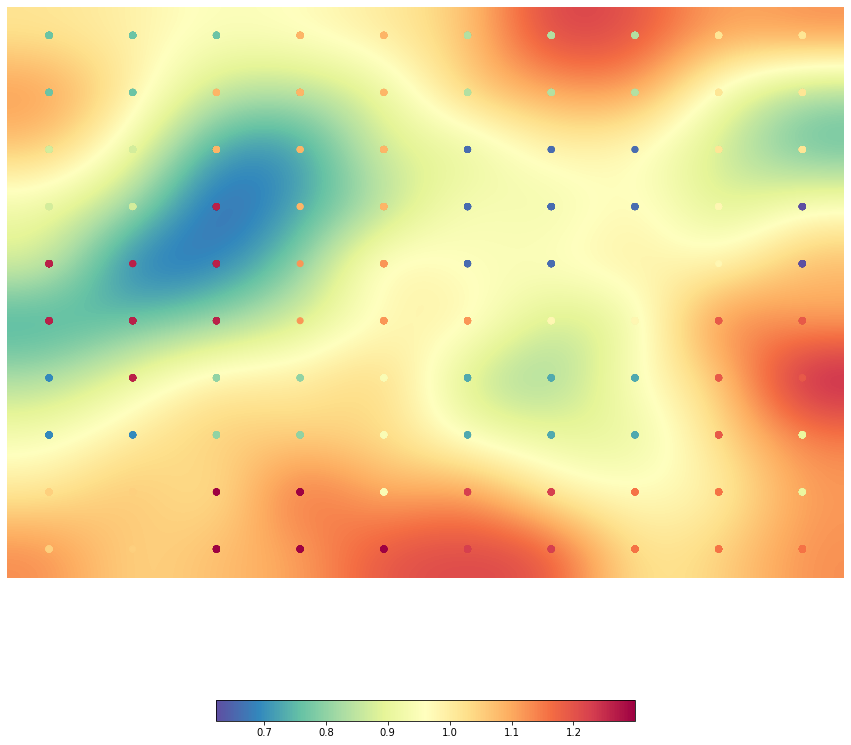

In [96]:
print(som_10.clusters)
print()
unique_values, counts = np.unique(som_10.clusters, return_counts=True)
arr = np.asarray((unique_values, counts))
sorted_arr = arr[ :, arr[1].argsort()]
print("\033[1m Clusters sorted by increasing number of neurons: \033[0m")
print("Cluster index")
print("Number of neurons")
print(sorted_arr)
print()
som_10.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15)); matplotlib.pyplot.show()

Ήδη εποπτικά μπορούμε κάπως να διακρίνουμε ορισμένες περιοχές (clusters), αυτές που ξεχωρίζουν με μπλε χρώμα, γεγονός που σημαίνει ότι λειτουργεί αρκετά ικανοποιητικά το clustering.


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [97]:
def print_categories_stats(IDs):
    total_categories = []                                                                        # Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών
    for movie_id in IDs:                                                                         # Για κάθε ταινία (movie_id) στην λίστα εισόδου IDs
        movie_categories = categories[movie_id][0].split(",")  # list                            # Δημιουργούμε μία λίστα με τις κατηγορίες της διαχωρίζοντας το string κατάλληλα με την split
        for i in range(len(movie_categories)):                                                   # Σε κάθε μία από αυτές αφαιρούμε τα whitespaces μεταξύ ετικετών με την strip  
            total_categories.extend([movie_categories[i].strip()])                               # και την κάνουμε extend στην λίστα συνολικών κατηγοριών
    unique_categories, counts = np.unique(total_categories, return_counts=True)                  # Βρίσκουμε τη συχνότητα μοναδικών ετικετών κατηγοριών
    largest_categories_indexes = np.argsort(counts)[::-1]                                        # Ταξινομούμε τις κατηγορίες σε φθίνουσα σειρά συχνοτήτων
    result = [(unique_categories[index],counts[index]) for index in largest_categories_indexes]  # Δημιουργούμε την τελική ταξινομημένη λίστα από tuples της μορφής (Category, Counts)
    print("Overall Cluster Genres stats:\n")                                                       # Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα
    print(result)
    return result                                                                                # Επιστρέφουμε την τελική λίστα με τις στατιστικές των κατηγοριών των ταινιών

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [98]:
def print_cluster_neurons_movies_report(cluster_number, som, ubmus):
    row_indexes, column_indexes = np.where(som.clusters==cluster_number)        # Βρίσκουμε τις συντεταγμένες όλων των νευρώνων που ανήκουν στο cluster
    cluster_bmus = np.column_stack((column_indexes,row_indexes))                # Φτιάχνουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη-γραμμή) (ανάποδα από ότι στην python) στον πίνακα bmus 
    cluster_bmus_indices  = []                                                  # Αρχικοποιούμε μία λίστα με τους αριθμούς των νευρώνων
    for cluster_bmu in cluster_bmus:                                            # Για κάθε bmu 
        if (ubmus == cluster_bmu).all(axis=1).any():                            # ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus (ubmus)
            bmus_number = np.where(np.all(cluster_bmu==ubmus,axis=1))[0][0]     # και αν υπάρχει βρίσκουμε την αντίστοιχη γραμμή
            cluster_bmus_indices.append(bmus_number)                            # και την κάνουνε append στην λίστα 
    return cluster_bmus                                                         # Επιστρέφουμε τον πίνακα bmus για το cluster

In [99]:
                                                      # Επιστρέφω τον πίνακα  bmus για το cluster

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.
​
Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.
​
Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 
​
Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):
​
```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [100]:
import itertools

def neuron_movies_report(som,neurons):
    cluster_movies_ids = []                                                          # Αρχικοποιώ μία λίστα με τα IDs των ταινιών που ανήκουν στο σύνολο των νευρώνων
    for neuron in neurons:                                                           # Για κάθε νευρώνα
        if (som.bmus == neuron).all(axis=1).any():                                   # ελέγχω αν υπάρχει στον πίνακα των bmus του som
            cluster_movies_ids.append(np.where(np.all(som.bmus==neuron,axis=1))[0])  # και αν υπάρχει βρίσκω τις αντίστοιχες γραμμές οι οποίες συμπίπτουν με τα IDs των ταινιών 
    return list(itertools.chain.from_iterable(cluster_movies_ids))                   # Επιστρέφω την λίστα με τα IDs των ταινιών                            # Τυπώνουμε τις στατιστικές των κατηγοριών

In [101]:
cluster_coordinates = print_cluster_neurons_movies_report(0, som_10, unique_bmus_10)
cluster_movies_ids = neuron_movies_report(som_10, cluster_coordinates) 
_ = print_categories_stats(cluster_movies_ids)



Overall Cluster Genres stats:

[('"Comedy"', 65), ('"Black-and-white"', 30), ('"Short Film"', 19), ('"Slapstick"', 11), ('"Parody"', 10), ('"War film"', 5), ('"Screwball comedy"', 4), ('"Western"', 4), ('"Comedy-drama"', 4), ('"Crime Fiction"', 4), ('"Satire"', 3), ('"Japanese Movies"', 3), ('"Sports"', 3), ('"Musical"', 3), ('"Cult"', 3), ('"Period piece"', 2), ('"Romance Film"', 2), ('"World cinema"', 2), ('"Comedy Western"', 2), ('"Science Fiction"', 2), ('"Silent film"', 2), ('"Black comedy"', 2), ('"Domestic Comedy"', 2), ('"Action/Adventure"', 2), ('"Drama"', 2), ('"Indie"', 2), ('"Buddy film"', 1), ('"Crime Comedy"', 1), ('"Comedy of manners"', 1), ('"Foreign legion"', 1), ('"Adventure"', 1), ('"Action"', 1), ('"Family Film"', 1), ('"Martial Arts Film"', 1), ('"Gangster Film"', 1), ('"Romantic comedy"', 1), ('"Teen"', 1), ('"Sword and Sandal"', 1), ('"Surrealism"', 1), ('"Stoner film"', 1), ('"Sex comedy"', 1), ('"Samurai cinema"', 1), ('"Prison"', 1), ('"Gross out"', 1), ('"Mus

Φτιάχνουμε τώρα μία συνάρτηση ώστε, με την βοηθεια των παραπάνω συναρτήσεων που υλοποιήσαμε, να εντοπίσουμε τον συνδυασμό διαστάσεων χάρτη SOM και τιμλης της υπερπαραμέτρου k που να δίνει καλύτερα αποτελέσματα.

In [102]:
def test_som(som,unique_bmus,k):
    som.cluster(KMeans(n_clusters=k))                                           # Εφαρμόζουμε τον αλγόριθμο συσταδοποίησης KMeans με k γείτονες
    print("-------------------------------------------------------------- k = {}  --------------------------------------------------------------".format(k))
    print("\n")
    print("Som Clusters")
    print(som.clusters)                                                         # Τυπώνουμε απευθείας τη μεταβλητή clusters για μία πιο ξεκάθαρη απεικόνιση του clustering
    print("\n")
    unique_values, counts = np.unique(som.clusters, return_counts=True)         # Βρίσκουμε τις μοναδικές συστάδες και τις συχνότητές τους
    arr = np.asarray((unique_values, counts))                                   # Φτιάχνουμε έναν πίνακα με τον αριθμό των συστάδων στην πρώτη γραμμή και τις ανίστοιχες συχνότητές τους στην δεύτερη
    sorted_arr = arr[ :, arr[1].argsort()]                                      # Ταξινομούμε τον πίνακα σε αύξουσα σειρά συχνοτήτων (αριθμού νευρώνων)
    print("\033[1m Clusters sorted by increasing number of neurons:\033[0m")
    print("Cluster index")
    print("Number of neurons")
    print(sorted_arr)                                                           # Τυπώνουμε τον ταξινομημένο πίνακα
    print()
    for i in range(k):                                                          # Για κάθε cluster από τα k που σχηματίζει ο αλγόριθμος τυπώνουμε την στατιστική των κατηγοριών των ταινιών που ανήκουν σε αυτό
        print("---------------------------------------------------------------------------------\033[1m Cluster {} \033[0m---------------------------------------------------------------------------------".format(i))
        print()
        cluster_coordinates = print_cluster_neurons_movies_report(i,som,unique_bmus)
        cluster_movies_ids = neuron_movies_report(som,cluster_coordinates)
        _ = print_categories_stats(cluster_movies_ids)
        print()
    som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15)); matplotlib.pyplot.show()  # Τυπώνουμε τον U-Matrix

In [103]:
np.set_printoptions(linewidth=np.inf)                                           # Προκειμένου να εκτυπώνεται ολόκληρη η γραμμή του πίνακα som σε μία γραμμή αντί να σπάει σε δύο (για μεγαλύτερες διαστάσεις som)


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


## **Testing**
Στη συνέχεια θα εξετάσουμε τις διαστάσεις grid **10x10, 20x20, 30x30, 40x40** για τιμές **k = {15, 20, 25, 30}**.

## 10x10, k = 15

-------------------------------------------------------------- k = 15  --------------------------------------------------------------


Som Clusters
[[10 10  9  9  7 14 14 14  3  3]
 [10 10  9  9  7 14 14 14  3  3]
 [13  9  9  9  7  7  2  2  3  3]
 [13  9  9  9  7  2  2  2  3  3]
 [13  0  0  0  6  2  2  2  3  3]
 [ 0  0  0  0  6  6  6  6  1  1]
 [ 0  0  0  0  6  6  6  1  1  1]
 [ 5  5  0 11 11 12 12  1  1  1]
 [ 5  5 11 11  4 12 12  8  8  8]
 [ 5  5 11 11  4 12 12  8  8  8]]


 Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 4 13 10  7  5  8 11 12 14  1  2  6  3  9  0]
 [ 2  3  4  5  6  6  6  6  6  8  8  8 10 10 12]]

--------------------------------------------------------------------------------- Cluster 0 ---------------------------------------------------------------------------------

Overall Cluster Genres stats:

[('"Drama"', 183), ('"War film"', 28), ('"Black-and-white"', 25), ('"Action"', 19), ('"Thriller"', 17), ('"Adventure"', 13), ('"Musi

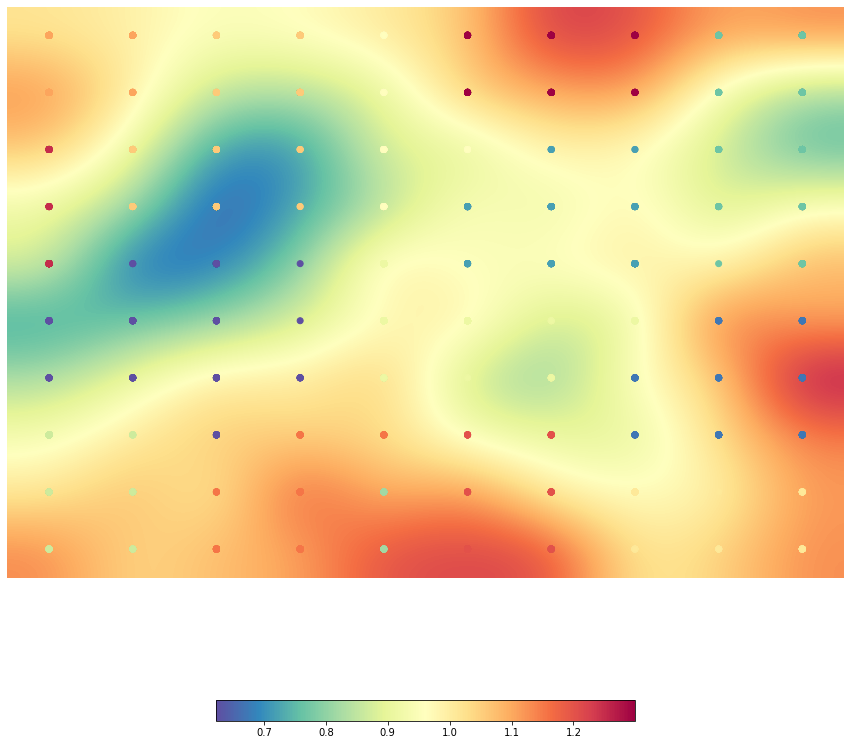

In [104]:
test_som(som_10, unique_bmus_10, 15)

## 10x10, k = 20

-------------------------------------------------------------- k = 20  --------------------------------------------------------------


Som Clusters
[[13 13  3  3 18  9  9  9  6  6]
 [13 13  3  3 18 18  9  9  6  6]
 [15 15  3  3 18 18  0  0  6  6]
 [15 15  3  3 18 18  0  0 10 10]
 [ 5  5  5 11 11 18  0  0 10 10]
 [ 5  5  5 11 11 14 14 14 16 16]
 [ 5  5  5  5 14 14 14 14 16 16]
 [ 1  1  1 17 17 14 14  7  7  7]
 [12  1  8  8 17  4  2  2  7  7]
 [12 12 19 19 17  4  2  2  2  7]]


 Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[19  4  8 12  1 17 16 15 13 11 10  9  2  7  6  0  3 18 14  5]
 [ 2  2  2  3  4  4  4  4  4  4  4  5  5  6  6  6  8  8  9 10]]

--------------------------------------------------------------------------------- Cluster 0 ---------------------------------------------------------------------------------

Overall Cluster Genres stats:

[('"Horror"', 105), ('"Thriller"', 34), ('"Science Fiction"', 21), ('"Slasher"', 19), ('"World cinema"

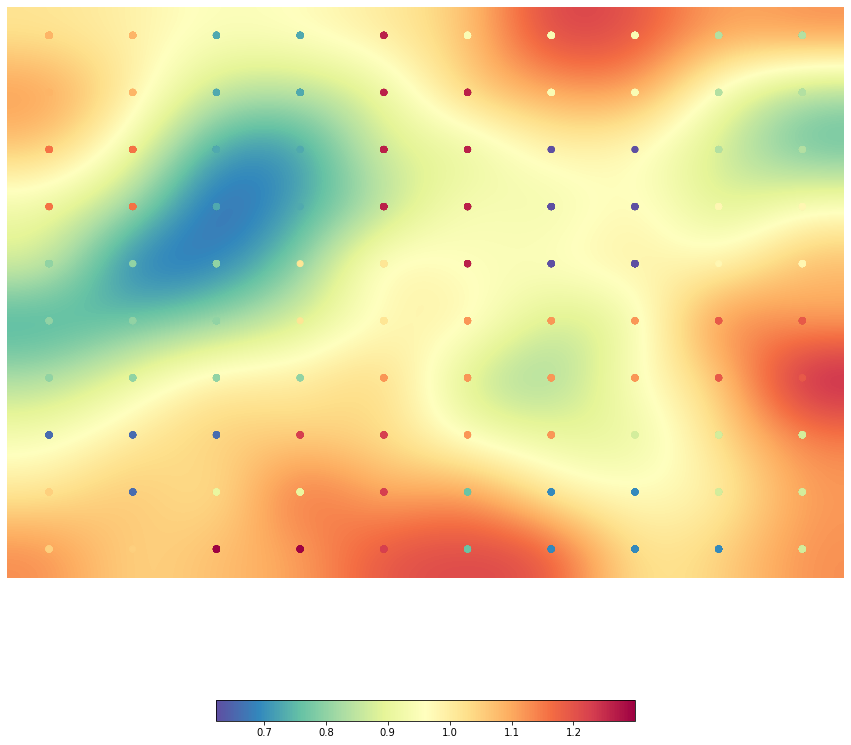

In [105]:
test_som(som_10, unique_bmus_10, 20)

## 10x10, k = 25

-------------------------------------------------------------- k = 25  --------------------------------------------------------------


Som Clusters
[[11 11  0  3 17  6 22 22  4  4]
 [20 20  3  3 17  6  6  6  4  4]
 [10 10  3  3 17 17  9  7  4  4]
 [10  0  0  3 17  9  9  9  7  7]
 [ 0  0  0 13 13  9  9  9  7  7]
 [ 1  1  1 13 13  8  8  8 19 19]
 [ 1  1 23 23 21  8  8  2 19 15]
 [ 1  1 23 23 21  8  8  2  2 12]
 [14 14  5  5 21 18 18  2 16 12]
 [14 14  5  5 24 18 18 16 16 16]]


 Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[24 15 22 20 11 12 21 10 19  6  2 23 13 14  5 16 18  7 17  3  4  0  9  8  1]
 [ 1  1  2  2  2  2  3  3  3  4  4  4  4  4  4  4  4  5  5  6  6  6  7  7  7]]

--------------------------------------------------------------------------------- Cluster 0 ---------------------------------------------------------------------------------

Overall Cluster Genres stats:

[('"Drama"', 156), ('"World cinema"', 44), ('"Romance Film"', 23), ('"In

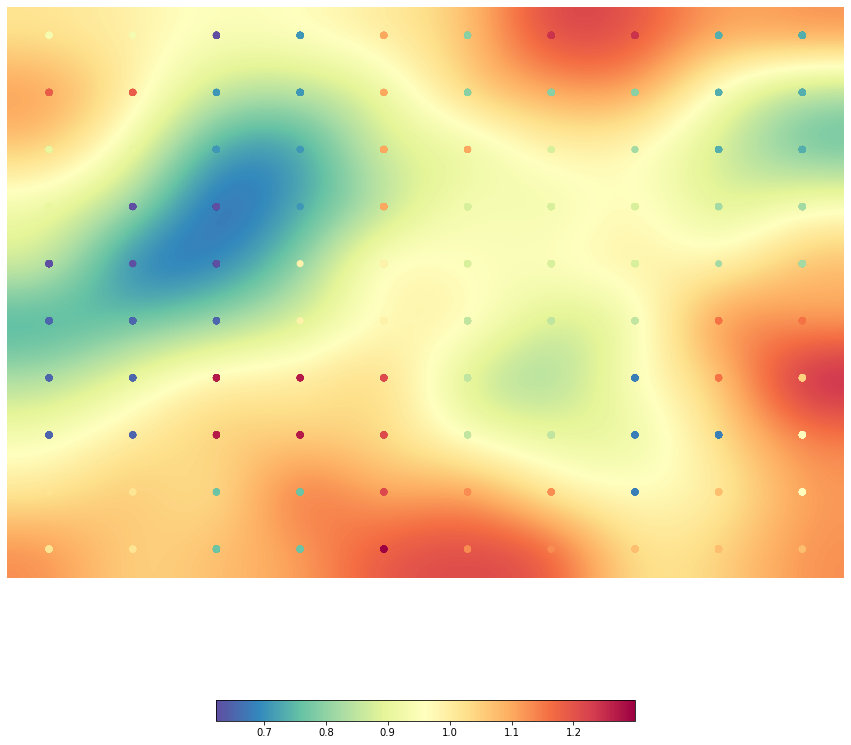

In [106]:
test_som(som_10, unique_bmus_10, 25)

## 10x10, k = 30

-------------------------------------------------------------- k = 30  --------------------------------------------------------------


Som Clusters
[[ 8  8  8 26 20 24  4  4 14 13]
 [ 8  8 26 26 27 20 24 24 14 14]
 [17 17  1 26 27 27 19  0 14 14]
 [18 15  1  1 27 19 19 19  0  0]
 [18 15 15 15 25  6 19 19  0  0]
 [15 23 23 23 25  6  9  9 11 11]
 [ 7 23 23 12  9  9  9  9 22 28]
 [ 7  7 12 12 12  9  9 16 22  3]
 [10 10  2 29 21  5  5 16 16  3]
 [10 10  2  2 21  5  5 16 16  3]]


 Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[29 28 13 20 18 17 25 21 11  6  4 22  7 24  3  2  1 26 10 12  5 27 23  0 16 15  8 14 19  9]
 [ 1  1  1  2  2  2  2  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5  5  5  6  8]]

--------------------------------------------------------------------------------- Cluster 0 ---------------------------------------------------------------------------------

Overall Cluster Genres stats:

[('"Comedy"', 77), ('"Black-and-white"', 3

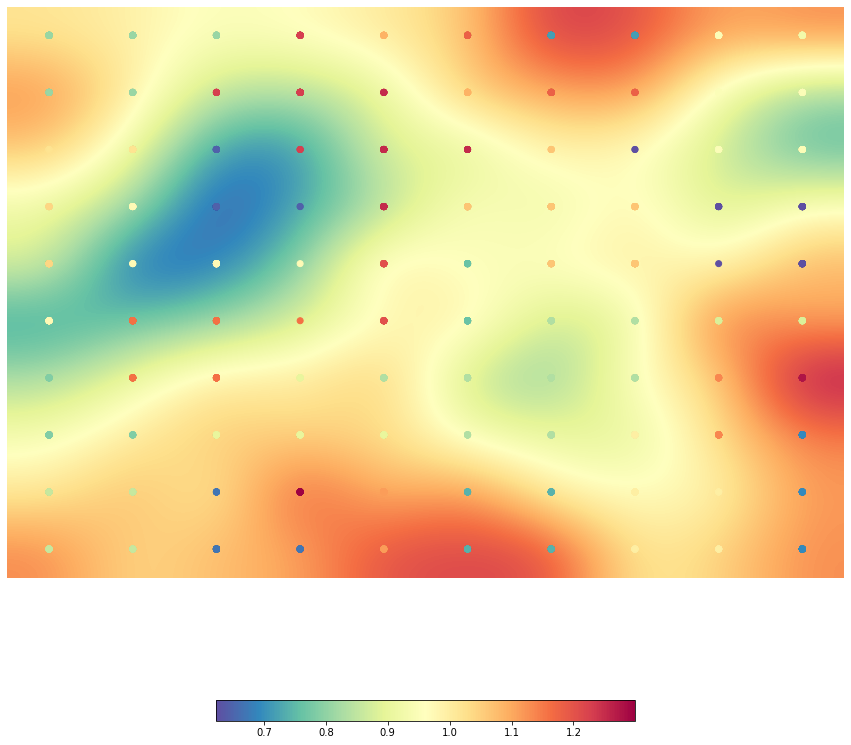

In [107]:
test_som(som_10, unique_bmus_10, 30)

## 20x20, k = 15

-------------------------------------------------------------- k = 15  --------------------------------------------------------------


Som Clusters
[[10 10 10 10 10  4  4  4  1  1  1  1  1  1  1  3 12 12 12 12]
 [10 10 10 10  4  4  4  4  1  1  1  1  1  1  1  3 12 12 12 12]
 [10 10 10 10  4  4  4  4  4  1  1  1  1  1  1  3 12 12 12 12]
 [10 10 10  4  4  4  4  4  4  1  1  1  1  1  1  1  3 12 12 12]
 [ 9  9 10  4  4  4  4  4  4  1  1  1  1  1  1  1  3  3 13 13]
 [ 9  9  9  0  0  4  4  4  4  4  1  1  1  1 13 13  3  3  3 11]
 [ 9  9  9  0  0  0  0  0  0  4  1  1 13 13 13 13 11 11 11 11]
 [ 9  9  9  0  0  0  0  0  0  0  3 13 13 13 13 13 11 11 11 11]
 [ 9  9  0  0  0  0  0  0  0  0  3  3 13 13 13 13 11 11 11 11]
 [ 9  9  0  0  0  0  0  0  0  0  3  3 13 13 13 13 11 11 11 11]
 [ 8  3  0  0  0  0  0  0  0  3  3  3  3 13 13 13 11 11 11 11]
 [ 8  8  7  7  7  7  7  7  7  3  3  3  3  3  3  3 14 11 11 11]
 [ 8  8  8  7  7  7  7  7  7  3  3  3  3  3  3  3 14 14 14 14]
 [ 8  8  8  8  7  7  7  7  7  7 

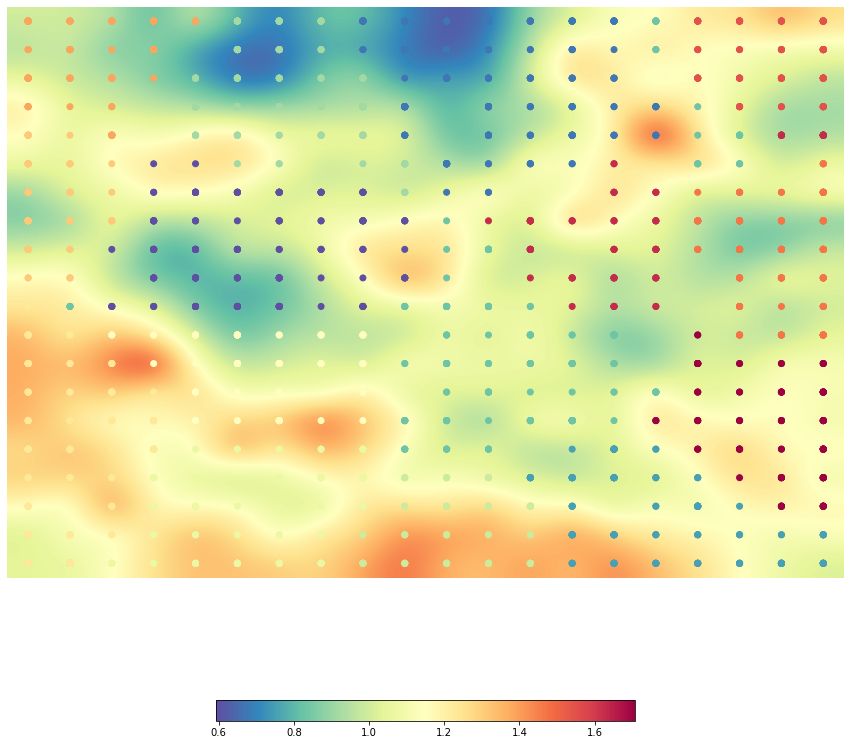

In [108]:
test_som(som_20, unique_bmus_20, 15)

## 20x20, k = 20

-------------------------------------------------------------- k = 20  --------------------------------------------------------------


Som Clusters
[[13 13 13 13 13  2  2 17  2  2  2  2  2  2  2  7  7  7  7  7]
 [13 13 13 13 17 17 17  2  2  2  2  2  2  2  2  7  7  7  7  7]
 [13 13 13 13 17 17 17  2  2  2  2  2  2  2  2  2  7  7  7  7]
 [13 13 13 17 17 17 17  2  2  2  2  2  2  2  2  2  7  7  7  7]
 [ 8  8  8 17 17 17 17 17  2  2  2  2  2  2  2  2  7  7  7  7]
 [ 8  8  8 17 17 17 17 16 16 16 16  2  2  2 12 12 12  7  7  7]
 [ 8  8  8 18 18 17 16 16 16 16 16  2 12 12 12 12 19 19 19 19]
 [ 8  8 18 18 18 18 16 16 16 16 16 12 12 12 12 12 19 19 19 19]
 [ 8  8 18 18 18 18 18 16 16 16 12 12 12 12 12 12 19 19 19 19]
 [18 18 18 18 18 18 18 18  6  6  6 12 12 12 12 12 19 19 19 19]
 [15 15 18 18 18 18 18 18  6  6  6 12  4 12 12 12 19 19 19 19]
 [15 15 15  0  0  0  0  6  6  6  6  4  4  4 12 12  1 19 19 19]
 [15 15 15  0  0  0  0  6  6  6  6  4  4  4  4  4  1  1  1  1]
 [15 15  9  0  0  0  0  0  6  6 

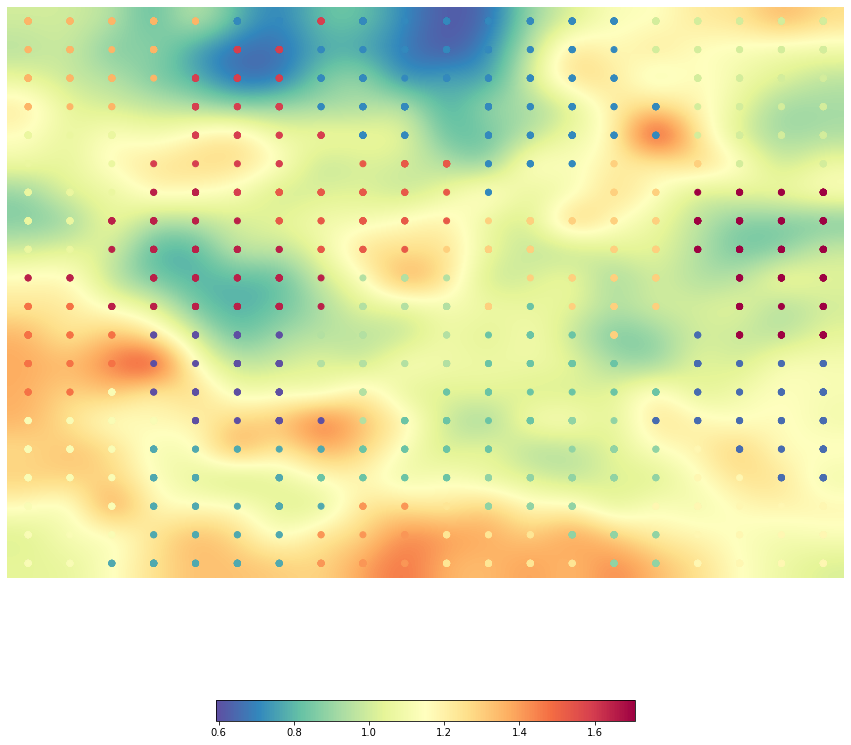

In [109]:
test_som(som_20, unique_bmus_20, 20)

## 20x20, k = 25

-------------------------------------------------------------- k = 25  --------------------------------------------------------------


Som Clusters
[[24 24  3  3  3 13 13 13  4  4  4  4  4  4  4  4 12 12 12 12]
 [24 24  3  3 13 13 13 13  4  4  4  4  4  4  4  1 12 12 12 12]
 [24 24 24  3 13 13 13 13  4  4  4  4  4  4  4  4 12 12 12 12]
 [24 24  3 13 13 13 13 13  4  4  4  4  4  4  4  4 16 16 16 16]
 [11  3  3  3 13 13 13 13 13  4  4  4  4  4  4  4 16 16 16 16]
 [11 11 11  5  5  5  5  0  0  0  0  4  4  4  8  8 16 16 16 16]
 [11 11 11  5  5  5  5  0  0  0  0  4  8  8  8  8  7  7  7  7]
 [11 11 11  5  5  5  5  0  0  0  0  8  8  8  8  8  7  7  7  7]
 [11 11  5  5  5  5  5  5  0  0  8  8  8  8  8  8  7  7  7  7]
 [11 11  5  5  5  5  5  5 18 17 17  8  8  8  8  8  7  7  7  7]
 [15 15 15  5  5  5  5 18 18 17 17  1  1  8  8  8 23 23 23 23]
 [15 15 15 15 20 20 20 18 18 18 17  1  1  1  1  1 23 23 23 23]
 [15 15 15 15 20 20 20 20 18 18  1  1  1  1  1  1 23 23 23 22]
 [15 15  2  2  2 20 20 20 20 20 

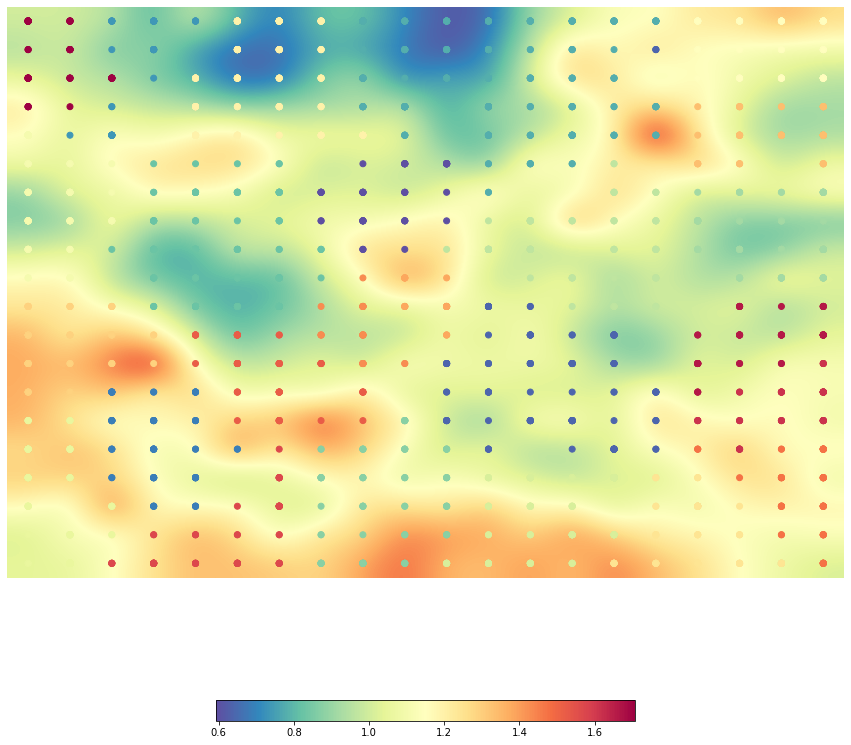

In [110]:
test_som(som_20, unique_bmus_20, 25)

## 20x20, k = 30

-------------------------------------------------------------- k = 30  --------------------------------------------------------------


Som Clusters
[[18 18 18  3  3  3  3  3 17 17 17 17 17 17 15  7  7  7 22 22]
 [18 18 18  3  3  3  3  3 17 17 17 17 17 17 15  7  7  7 22 22]
 [18 18 18  3  3  3  3  3 17 17 17 17 17 15 15  7  7 22 22 22]
 [18 18 18  3  3  3  3  3 17 17 17 17 17 15 15 15  7 22 22 22]
 [ 9  9  9  3  3  3  3  3  3 17 17 17 15 15 15 15  7 10  8  8]
 [ 9  9  9 25 25 25 14 14 14  3 17 17 17 15 15  8  8  8  8  8]
 [ 9  9  9 25 25 25 14 14 14 14 17 17  1  1  8  8  8  8 11 11]
 [ 9  9  9 16 25 25 14 14 14 14  1  1  1  1  8  8  8 11 11 11]
 [ 9  9 16 16 16 16 16 14 14 14  1  1  1  1  8  8  8 11 11 11]
 [16 16 16 16 16 16 16 16  5  5  5  1  1  1  8  8  8 11 11 11]
 [28 28 16 16 16 16 16 16  5  5  5 10 10 10 10 10 27 11 11 11]
 [28 28 28 16 16 16 16  5  5  5  5 10 10 10 10 10 27 27 11 11]
 [28 28 28  4 16 16 16  5  5  5  5 10 10 10 10 10 27 27 12 12]
 [28 28  4  4  4  0  0  0  5  5 

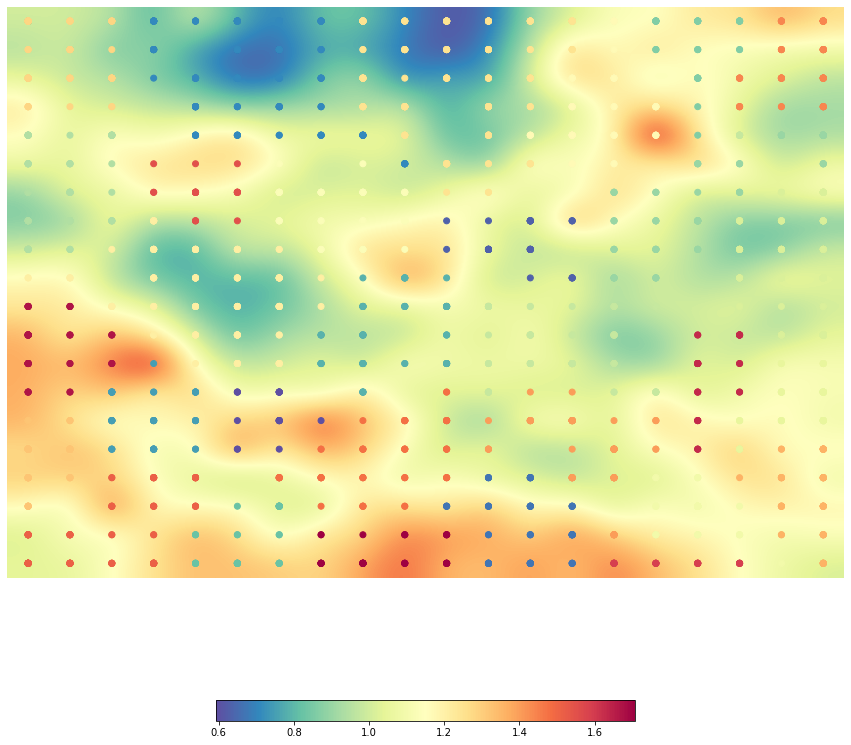

In [111]:
test_som(som_20, unique_bmus_20, 30)

## 25x25, k = 15

-------------------------------------------------------------- k = 15  --------------------------------------------------------------


Som Clusters
[[10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9  8  8  8  8  8  8  8  8  8]
 [10 10 10 10 10 10  9  9  9  9  9  9  9  9  9 12  8  8  8  8  8  8  8  8  8]
 [10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9  8  8  8  8  8  8  8  8  8]
 [10 10 10 10 10 10 10  9  9  9  9  9  9  9 12 12  8  8  8  8  8  8  8  8  8]
 [10 10 10 10 10 10 10  9  9  9  9 12  9 12 12 12 12  8  8  8  8  8  8  8  8]
 [10 10 10 10 10 10 10 12 12 12 12 12 12 12 12 12 12 12  8  8  5  5  5  8  8]
 [10  0  0 10  0 12 12 12 12 12 12 12 12 12 12 12 12 12 12  5  5  5  5  5  5]
 [ 0  0  0  0  0  0 12 12 12 12 12 12 12 12 12 12 12 12 12  5  5  5  5  5  5]
 [ 0  0  0  0  0  0 12 12 12 12 14 14 14 14 14 12 12 12 12  5  5  5  5  5  5]
 [ 0  0  0  0  0  0 12 12 12 12 14 14 14 14 14 14 14 12  5  5  5  5  5  5  5]
 [ 7  7  0  0  0 12  6  6 12 12 14 14 14 14 14 14 14  5  5  5  5  5  5 

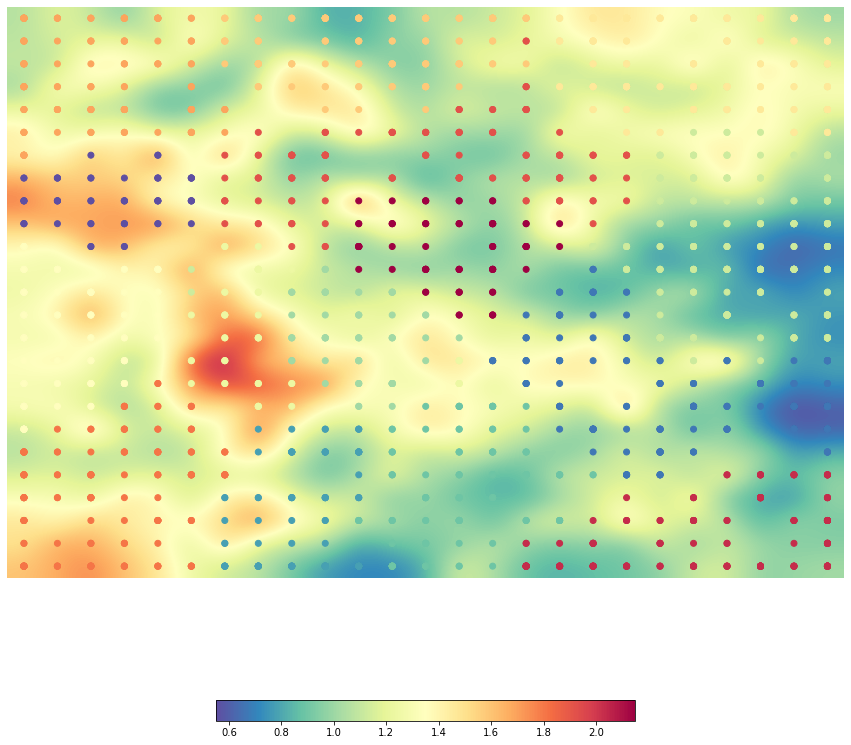

In [112]:
test_som(som_25, unique_bmus_25, 15)

## 25x25, k = 20

-------------------------------------------------------------- k = 20  --------------------------------------------------------------


Som Clusters
[[18 18 18 18 18 18  3  3  3  3  3  3  3  3  3  3 16 16  8  8  8  8  8  8  8]
 [18 18 18 18 18 18  3  3  3  3  3  3  3  3  3 16 16  8  8  8  8  8  8  8  8]
 [18 18 18 18 18 18  3  3  3  3  3  3  3  3  3 16 16  8  8  8  8  8  8  8  8]
 [18 18 18 18 18 18 18  3  3  3  3  3  3  3 16  0  0  0  0  8  8  8  8  8  8]
 [18 18 18 18 18 18 18  3  3  3  3  0  3  0  0  0  0  8  0  8  8  8  8  8  8]
 [18 18 18 18 18 18 18  0  0  0  0  0  0  0  0  0  0  0  0  8  4  4  4  4  4]
 [18 14 14 18 16 16  0  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4  4  4]
 [14 14 14 14 14 16 16 16  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4  4  4]
 [14 14 14 14 14 16 16 16  0  0  0  0 17 17 17  0  0  0  0  4  4  4  4  4  4]
 [14 14 14 14 14 16 16 16 16  0 19  1 17 17 17 17 17  0 11 11  4  4  4  4  4]
 [12 12 14 14 14 16 16 16 19 19 19 19 17 17 17 17 17 11 11 11 11 11 11 

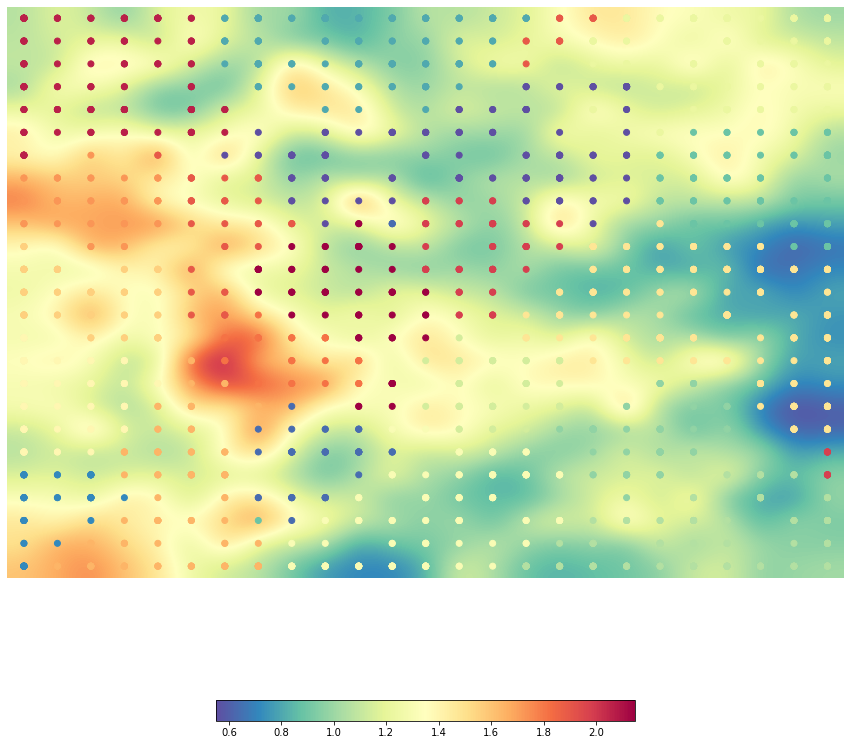

In [113]:
test_som(som_25, unique_bmus_25, 20)

## 25x25, k = 25

-------------------------------------------------------------- k = 25  --------------------------------------------------------------


Som Clusters
[[ 7  7  7  7  7 19 19 19 18 18 18 18 18 18 18 13 13 13  6  6  6  6  6  6  6]
 [ 7  7  7  7  7 19 19 19 19 18 18 18 18 18 18 13 13 13 13  6  6  6  6  6  6]
 [ 7  7  7  7  7 19 19 19 19 18 18 18 18 18 18 13 13 13  8  6  6  6  6  6  6]
 [21 21 21 21 19 19 19 19 18 18 18 18 18 18 13 13 13 13  8  8  6  6  8  8  8]
 [21 21 21 21 21 19 19 19 18 18 18 16 18 16 13 13 13  8  8  8  8  8  8  8  8]
 [21 21 21 21 21 21 21 16 16 16 16 16 16 16 16  5  5  5  8  8  8 17  8  8  8]
 [21 21 12 21 21 21 16 16 16 16 16 16 16 16  5  5  5  5  5  8 17 17 17  8  8]
 [12 12 12 12 12 16 16 16 16 16 16 16 16 16 16  5  5  5  5 17 17 17 17 17 17]
 [12 12 12 12 12 16 16 16 16 16 16 24 24 24 24  5  5  5  5 11 17 17 17 17 17]
 [12 12 12 12 12 16 16 16 16 16 16 24 24 24 24 24 24 11 11 11 11 17 17 17 17]
 [14 14 12 12 12 16 13 13 16 16 16 24 24 24 24 24 24 11 11 11 11 11 11 

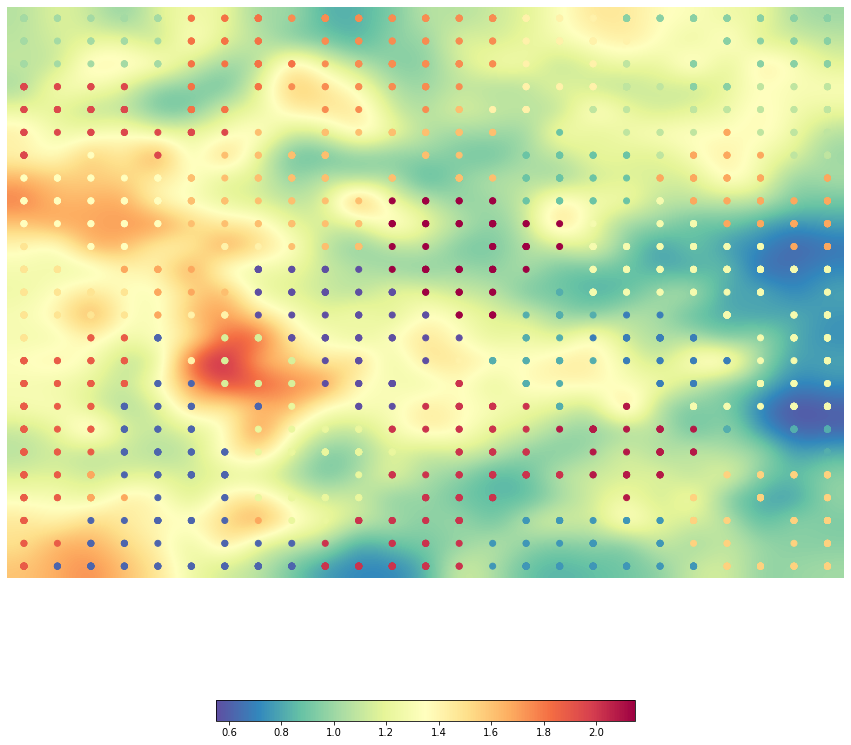

In [114]:
test_som(som_25, unique_bmus_25, 25)

## 25x25, k = 30

-------------------------------------------------------------- k = 30  --------------------------------------------------------------


Som Clusters
[[13 29 29 29 29 29 29  8  8  8  8  8  8  8  8 26 26 26 26 26  2  2  2 11 11]
 [13 13 29 29 29 29 29  8  8  8  8  8  8  8  8 26 26 26 26 26  2  2  2 11 11]
 [13 13 13 29 29 29  8  8  8  8  8  8  8  8  8  5  5  5 26  2  2  2  2  2 11]
 [13 13 13 29 29 11 11  8  8  8  8  8  8  8  5  5  5  5 27  2  2  2  2  2 16]
 [13 13 13 13 11 11 11 11  8  8  8 27  8 27  5  5  5 16 16  2  2  2  2 16 16]
 [13 13 13 11 11 11 11 27 27 27 27 27 27 27 27  5 23 16 16 16 16  1 16 16 16]
 [13 13 17 11 11 11 27 27 27 27 27 27 27 27 27 23 23 23 16 16 16 16 16  1  1]
 [ 6  6  6 21 21 21 27 27 27 27 27 10 10 10 10 23 23 23 16 16 16 16  1  1  1]
 [ 6  6  6 21 21 21 27 27 27 27 27 10 10 10 10 23 23 23 10  1  1  1  1  1  1]
 [ 6  6  6 21 21 21 27 27 27 27 18 18 10 10 10 10 10 10  1  1  1  1  1  1  1]
 [24 24 17 17 17 17  5  5 27 18 18 18 18 10 10 10 10  1  1  1  1  1  1 

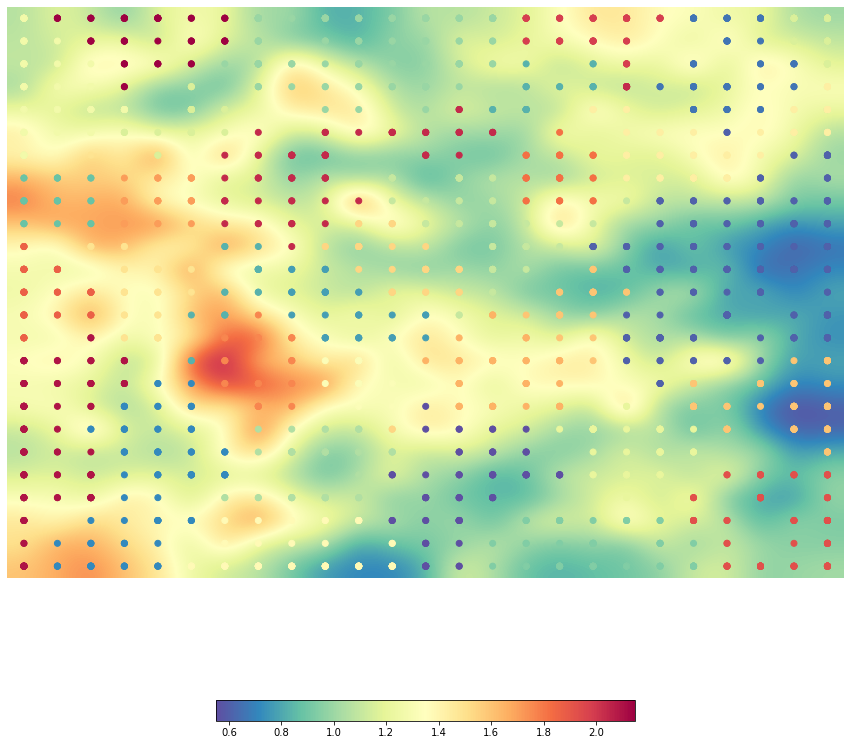

In [115]:
test_som(som_25, unique_bmus_25, 30)

## 30x30, k = 15

-------------------------------------------------------------- k = 15  --------------------------------------------------------------


Som Clusters
[[ 1  1  1  1  1  1  1  6  6  6  6  6  6  4  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3  3]
 [ 1  1  1  1  1  1  1  6  6  6  6  6  6  4  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3  3]
 [ 1  1  1  1  1  1  1  6  6  6  6  6  6  4  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3  3]
 [ 1  1  1  1  1  1  1  6  6  6  6  6  6  6  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3  3]
 [ 1  1  1  1  1  1  1  6  6  6  6  6  6  6  6  4  4  4  4  4  4  4  4  4  2  3  3  3  3  3]
 [ 1  1  1  1  1  1  6  6  6  6  6  6  6  6  6  4  4  4  4  4  4  2  2  2  2  7  3  3  3  3]
 [ 1  1  1  1  1  1  6  6  6  6  6  6  6  6  6  4  4  4 13 13 13  2  7  2  2  3  3  3  3  3]
 [ 1  1  1  1  1  6  6  6  6  6  6  6  6  6  6  5 13 13 13 13 13 13 13  2  2  2  3  3  3  3]
 [ 1  1  1  1  6  6  6  6  6  6  6  6  6  6  5  5 13 13 13 13 13 13 13  2  2 13 13  3  3  3]
 [ 1  1  1  1 

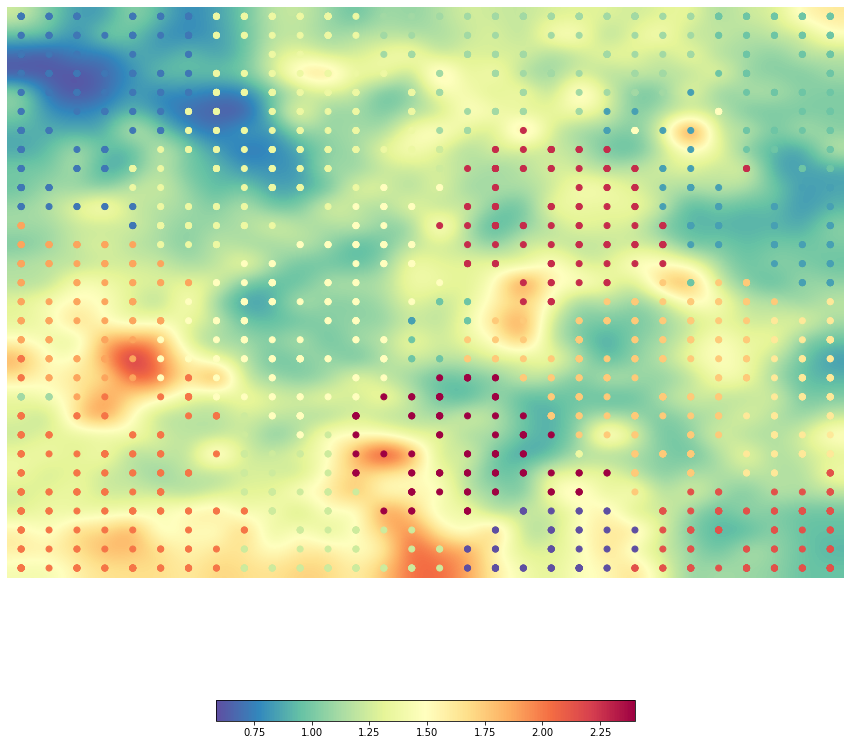

In [116]:
test_som(som_30, unique_bmus_30, 15)

## 30x30, k = 20

-------------------------------------------------------------- k = 20  --------------------------------------------------------------


Som Clusters
[[18 18 18 18 18 18 18  0  0 15 15 15 15 15 15 15  7 16  7  7  7  7  7  7  7 17 17 17 17 17]
 [18 18 18 18 18 18 18  0  0 15 15 15 15 15 15 15  7  7  7  7  7  7  7  7  7 17 17 17 17 17]
 [18 18 18 18 18 18 18  0  0  0  0 15 15 15 15 15  7  7  7  7  7  7  7  7  7 17 17 17 17 17]
 [18 18 18 18 18 18 18  0  0  0 15 15 15 15 15 15  7  7  7  7  7  7  7  7  7 17 17 17 17 17]
 [18 18 18 18 18 18 18  0  0  0  0  0  0  0  0  7  7  7  7  7  7  7  7  7  3  3 17 17 17 17]
 [18 18 18 18 18 18  0  0  0  0  0  0  0  0  0  7  7  7  7  7  7  3  3  3  3  3 17 17 17 17]
 [18 18 18 18 18 18  0  0  0  0  0  0  0  0  0  7  7  7  7  2  2  3  3  3  3  3 17 17 17 17]
 [18 18 18 18 18  0  0  0  0  0  0  0  0  0  0 14 14  2  2  2  2  2  2  2  3  3 17 17 17 17]
 [18 18 18 18  0  0  0  0  0  0  0  0  0  0 14 14  2  2  2  2  2  2  2  2  2  2  2 17  3 17]
 [18 18 18 18 

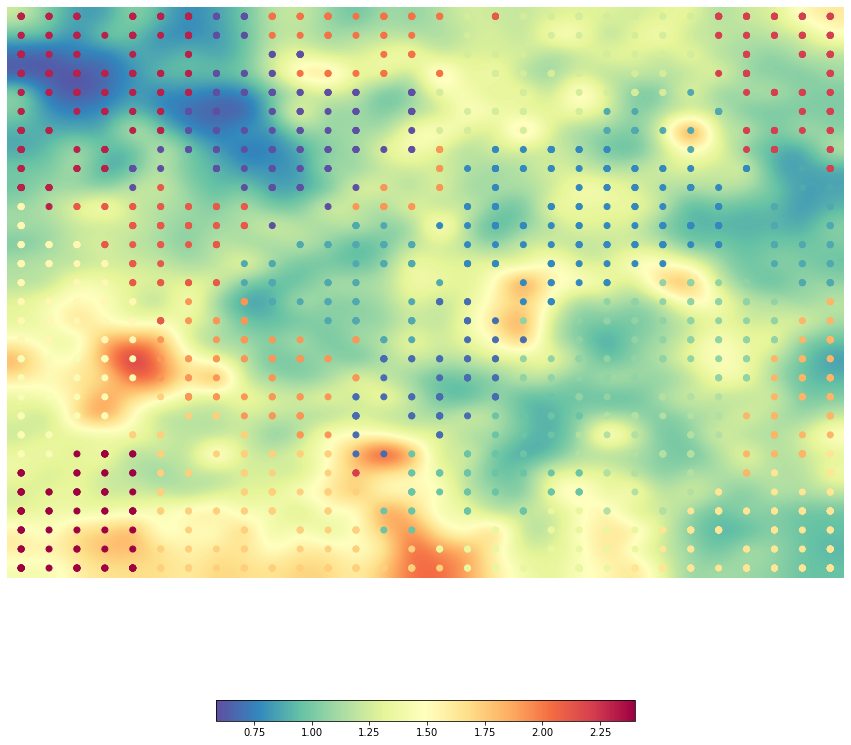

In [117]:
test_som(som_30, unique_bmus_30, 20)

## 30x30, k = 25

-------------------------------------------------------------- k = 25  --------------------------------------------------------------


Som Clusters
[[14 14 14 14 14 14  8  8  8  4  4  4  4  4  4  4  7  7  7  7  7 22 22 22 22 15  9  9  9  9]
 [14 14 14 14 14 14  8  8  8  4  4  4  4  4  4  7  7  7  7  7  7 22 22 22 22 15  9  9  9  9]
 [14 14 14 14 14  8  8  8  8  4  4  4  4  4  4  7  7  7  7  7  7 22 22 22 22 22  9  9  9  9]
 [14 14 14 14 14  8  8  8  8  8  4  4  8  4 22  7  7  7  7  7  7 22 22 22 22 13 13 13  9  9]
 [14 14 14 14 14  8  8  8  8  8  8  8  8  8  8 22 22  7  7  7 22 22 22 22 22 13 13 13 13 13]
 [14 14 14 14  8  8  8  8  8  8  8  8  8  8  8 22 22 22  7  7  7 12 22 22 13 13 13 13 13 13]
 [14 14 14 14  8  8  8  8  8  8  8  8  8  8 22 22 22 22 18 18 12 12 12 12 12 13 13 13 13 13]
 [ 8 14 14 14  8  8  8  8  8  8  8  8  8  8 22 22 22 18 18 18 12 12 12 12 12 13 13 13 13 13]
 [ 8 14 14  8  8  8  8  8  8  8  8  8  8  8  0  0 18 18 18 18 18 12 12  1  1  1 13 13 13 13]
 [12 14 14 14 

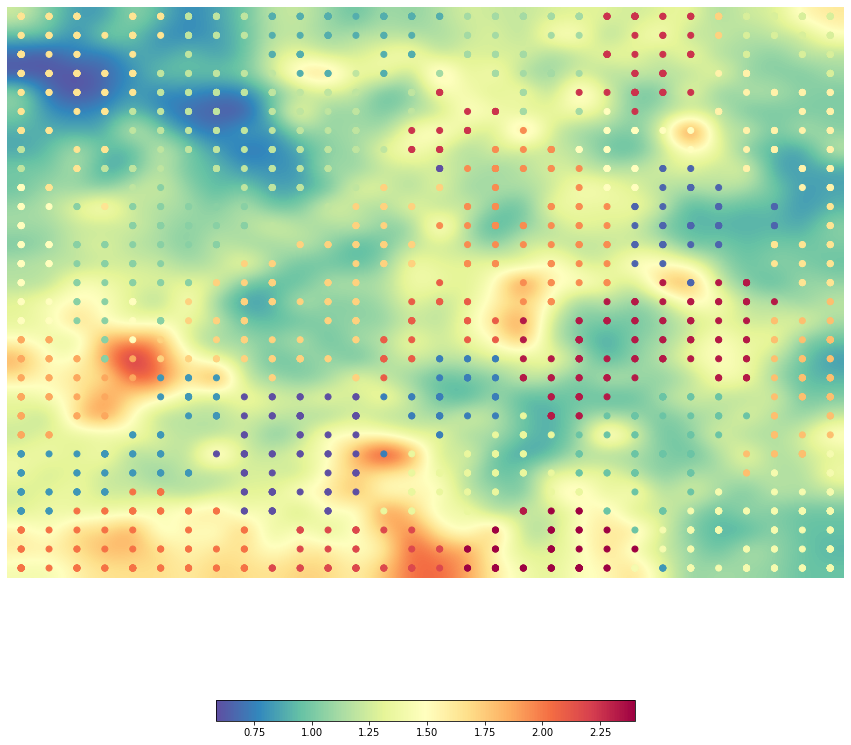

In [118]:
test_som(som_30, unique_bmus_30, 25)

## 30x30, k = 30

-------------------------------------------------------------- k = 30  --------------------------------------------------------------


Som Clusters
[[ 6  6  6  6  6  6  6  1  1  1  1  1 17 17 17 17 19 19 19 19 19 19  9  9  9 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  1  1  1  1  1 17 17 17 17 19 19 19 19 19 19  9  9  9 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  1  1  1  1  1 17 17 17 17 19 19 19 19 19 19  9  9  9 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  1  1  1  1  1  1 17 17 17 19 19 19 19 19  9  9  9  9 12 12 12 15 15]
 [ 6  6  6  6  6  6  6  1  1  1  1  1  1 17 17 17 17 19 19 19  9  9  9  9  9  9 12 15 15 15]
 [ 6  6  6  6  6  6  6  1  1  1  1  1  1 17 17 17 14 14 19 19  9  9  9  9  9  9 15 15 15 15]
 [ 6  6  6  6  6  6  1  1  1  1  1  1  1  1 17 17 14 14 14 14  9  3  3  3  9  9 15 15 15 15]
 [ 6  6  6  6  6  6  1  1  1  1  1  1  1  1 14 14 14 14 14 14 29 29  5  5  5 15 15 15 15 15]
 [ 6  6  6  6  6  6  1  1  1  1  1  1  1  1 14 14 14 14 14 29 29 29  5  5  5  5 15 15 15 15]
 [ 6  6  6  6 

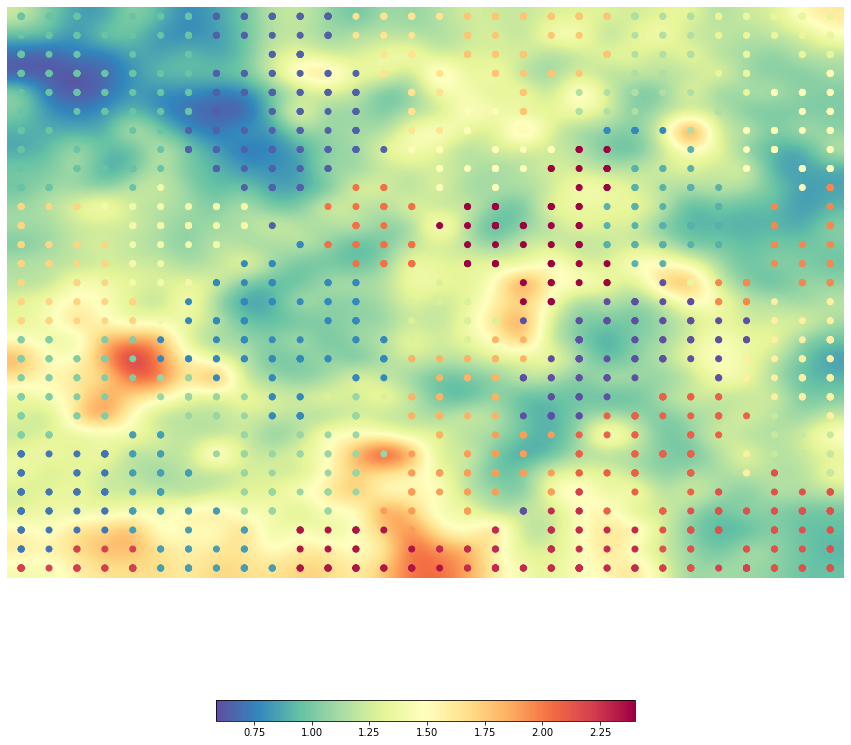

In [119]:
test_som(som_30, unique_bmus_30, 30)

## Συμπεράσματα
Παρατηρούμε ότι καλύτερη ομαδοποίηση, από τις δοκιμές μας, πετυχαίνεται στην περίπτωση 30x30 για αρίθμό clusters (k) 30. Αυτό μπορούμε να το καταλάβουμε από το γεγονός ότι ο πίνακας με τους νευώνες του SOM παρουσιάζει πιο καλά διαχωρισμένα clusters, ενώ ακόμα βλέπουμε πως για κάθε cluster έχουμε αρκετά λιγότερες διαφορετικές κατηγορίες, πράγμα που σημαίνει πως τα clusters έχουν μεγαλύτερη ειδικότητα.



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


## Clustering συνολικού dataset
Ακολουθούμε τώρα την ίδια διαδικασία με προηγουμένως για το συνολικό dataset μας.

In [120]:
final_set = joblib.load('final_set.pkl')

In [121]:
rows = 30
cols = 30
final_som = somoclu.Somoclu(cols, rows, compactsupport=False)
%time final_som.train(final_set, epochs=100)
joblib.dump(final_som, 'final_som.pkl') 

CPU times: user 8min 41s, sys: 1.28 s, total: 8min 43s
Wall time: 2min 17s


['final_som.pkl']

In [122]:
final_som = joblib.load('final_som.pkl')

In [123]:
bmus_final = final_som.bmus
print(bmus_final.shape)
print()
unique_bmus_final, indices = np.unique(bmus_final, return_inverse=True, axis=0)
print(unique_bmus_final.shape)

(5000, 2)

(832, 2)


[[ 0  0  0  0  0 27 27 27 27 27 11 11 29 29  6  6  6  6  8  8  8  8  8  8  8  8  8 12 12 12]
 [ 0  0  0  0  0 27 27 27 27 27 29 29 29 29 29 29 29 29  8  8  8  8  8  8  8  8  8 12 12 12]
 [ 0  0  0  0  0 25 27 27 27 27 29 29 29 29 29 29 29 29 29  8  8  8  8  8  8  8 12 12 12 12]
 [ 0  0  0  0 25 25 27 27 27 27 27 29 29 29 29 29 29 29 29 29 29  8  8  8  8  8 12 12 12 12]
 [ 6  0  0 25 25 25 25 27 27 27 27 29 29 29 29 29 29 29 29 29 29 28 18  8  8 12 12 12 12 12]
 [ 6  6  7 25 25 25 25 27 27 27  7 29 29 29 29 29 29 28 28 28 28 28 28 28  8 12 12 12 12 12]
 [ 6  6 25 25 25 25 25  7  7  7  7 29 29 29 29 29 28 28 28 28 28 28 28  6  6 12 12 12 12 12]
 [ 6 25 25 25 25 25  7  7  7  7  7  7 29 29 29 28 28 28 28 28 28 28 28  6  6  6 18 12 18 18]
 [19 19 19 19 25  7  7  7  7  7  7  7 26 26  7 18 28 28 28 28 28 28 28  6 18 18 18 18 18 18]
 [19 19 19 19 19  7  7  7  7  7  7 26 26 26 26 18 18  1 28 28 28 28  1  1 18 18 18 18 18 18]
 [19 19 19 19 19  7  7  7  7  7  7 26 26 26 26  1  1  1  1  1  1  1  1

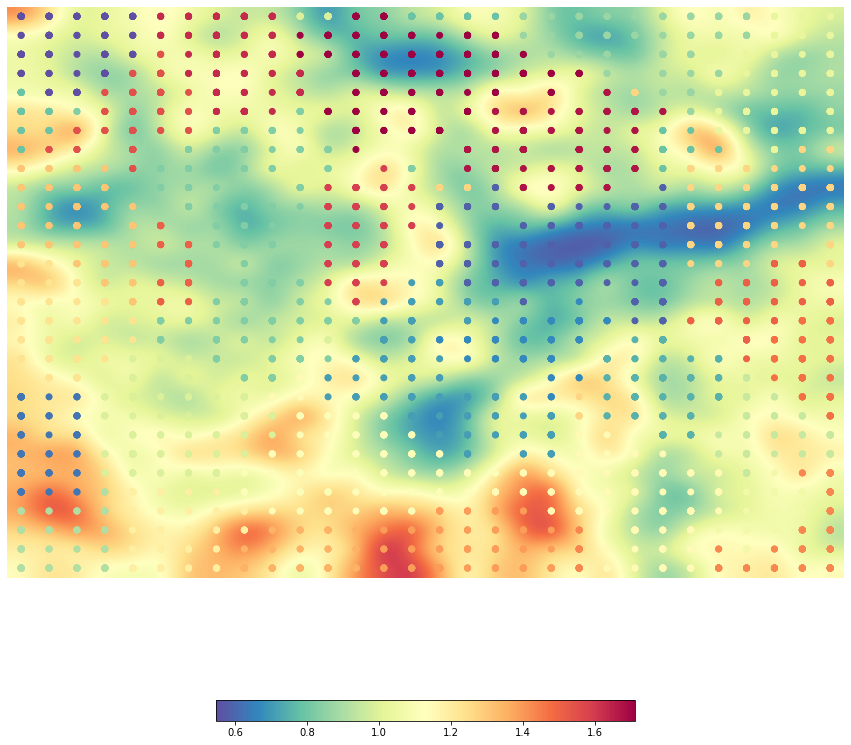

In [124]:
final_som.cluster(KMeans(n_clusters = 30))
print(final_som.clusters)
final_som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15)); matplotlib.pyplot.show()

In [125]:
joblib.dump(final_som, 'final_som_cluster.pkl') 

['final_som_cluster.pkl']

In [126]:
final_som = joblib.load('final_som_cluster.pkl')

In [127]:
unique_values, counts = np.unique(final_som.clusters, return_counts=True)
arr = np.asarray((unique_values, counts))
sorted_arr = arr[ :, arr[1].argsort()]
print("\033[1m Clusters sorted by increasing number of neurons for S1: \033[0m")
print("Cluster index")
print("Number of neurons")
print(sorted_arr)

 Clusters sorted by increasing number of neurons for S1: 
Cluster index
Number of neurons
[[13 23 20  6 10  9 22  2  0 25 16  3 21  5 17 27 24 26 12 19  8 28 14 11 18 15  4 29  1  7]
 [11 14 14 16 17 17 18 18 21 22 22 23 25 26 26 26 28 28 30 30 33 34 41 42 43 46 48 53 55 73]]


In [128]:
for i in range(30):
    print("_____________________________________________________________________________________________________________________________________________________________________________________________\n")
    print("                                                                                 Cluster {} ".format(i))
    print("_____________________________________________________________________________________________________________________________________________________________________________________________\n")
    cluster_coordinates = print_cluster_neurons_movies_report(i,final_som,bmus_final)
    cluster_movies_ids = neuron_movies_report(final_som,cluster_coordinates)
    _ = print_categories_stats(cluster_movies_ids)
    print()

_____________________________________________________________________________________________________________________________________________________________________________________________

                                                                                 Cluster 0 
_____________________________________________________________________________________________________________________________________________________________________________________________

Overall Cluster Genres stats:

[('"Animation"', 163), ('"Short Film"', 140), ('"Family Film"', 96), ('"Comedy"', 45), ('"Comedy film"', 40), ('"Musical"', 11), ('"Children\'s"', 9), ('"Fantasy"', 7), ('"Animated cartoon"', 4), ('"Black-and-white"', 4), ('"Stop motion"', 4), ('"Children\'s/Family"', 3), ('"Drama"', 3), ('"Western"', 3), ('"Propaganda film"', 2), ('"War film"', 2), ('"Romance Film"', 2), ('"Thriller"', 2), ('"Computer Animation"', 2), ('"Science Fiction"', 2), ('"Music"', 1), ('"Children\'s Fantasy"', 1), 

## 1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

Για να απαντήσουμε στο ερώτημα, θα τυπώσουμε μια λίστα που θα περιέχει ζευγάρια με τις καρηγορίες των ταινιών και τον αριθμό των νευρώνων στους οποίους εμφανίζεται η κάθε κατηγορία. Θα αντιπαραβάλλουμε τα ευρήματα που θα πάρουμε από αυτήν την λίστα με τις περισσότερο και λιγότερο συχνές κατηγορίες των ταινιών μας που είδαμε νωρίτερα.

In [129]:
categories_stats = print_categories_stats([i for i in range(5000)])
most_frequent_categories = categories_stats[0:5]
least_frequent_categories = categories_stats[-10:]
print()
print("--------------------------------------------------------------------------------- \033[1m 5 most frequent categories \033[0m ---------------------------------------------------------------------------------")
for cat in most_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(cat[0],cat[1]))
print("--------------------------------------------------------------------------------- \033[1m 10 least frequent categories \033[0m ---------------------------------------------------------------------------------")
for cat in least_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(cat[0],cat[1]))
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Overall Cluster Genres stats:

[('"Drama"', 2292), ('"Comedy"', 1206), ('"Romance Film"', 769), ('"Thriller"', 758), ('"Action"', 688), ('"World cinema"', 597), ('"Crime Fiction"', 525), ('"Horror"', 497), ('"Black-and-white"', 468), ('"Action/Adventure"', 437), ('"Indie"', 420), ('"Adventure"', 403), ('"Short Film"', 400), ('"Family Film"', 374), ('"Romantic drama"', 290), ('"Musical"', 289), ('"Science Fiction"', 288), ('"Animation"', 279), ('"Mystery"', 271), ('"Romantic comedy"', 238), ('"Fantasy"', 224), ('"Comedy film"', 217), ('"War film"', 194), ('"Crime Thriller"', 191), ('"Comedy-drama"', 164), ('"Silent film"', 155), ('"Period piece"', 150), ('"Western"', 146), ('"Japanese Movies"', 145), ('"Film adaptation"', 138), ('"Documentary"', 132), ('"Psychological thriller"', 128), ('"Bollywood"', 127), ('"Chinese Movies"', 121), ('"Black comedy"', 101), ('"Teen"', 100), ('"Children\'s/Family"', 91), ('"Family Drama"', 90), ('"Parody"', 89), ('"Sports"', 89), ('"Television movie"', 

In [130]:
def print_categories_stats(IDs):
    total_categories = []
    for movie_id in IDs:
        movie_categories = categories[movie_id][0].split(",")  
        for i in range(len(movie_categories)):
            total_categories.extend([movie_categories[i].strip()])
    unique_categories, counts = np.unique(total_categories, return_counts=True)
    largest_categories_indexes = np.argsort(counts)[::-1]
    result = [(unique_categories[index],counts[index]) for index in largest_categories_indexes]
    #print("Overall Cluster Genres stats:") 
    #print(result)
    return result

In [131]:
def number_of_neurons_in_category(category):
    cnt = 0                                                                     # Αρχικοποιούμε τον μετρητή με τους διαφορετικούς νευρώνες στους οποίους απεικονίζεται μία κατηγορίας
    for (cat,_) in neurons_categories_stats:                                    # Διατρέχουμε την λίστα neurons_categories_stats
        if cat==category:                                                       # και αν συναντήσουμε την κατηγορία που εξετάζουμε
           cnt+=1                                                               # αυξάνουμε τον μετρητή κατά ένα
    return cnt   

In [132]:
neurons_categories_stats = []                                                   # Αρχικοποιούμε μία λίστα με την στατιστική των κατηγοριών των ταινιών για όλους τους νευρώνες του πλέγματος
for i in range(20):  
    for j in range(20):                                                         # Για κάθε νευρώνα στο 20 x 20 grid
          neuron_IDs_list = neuron_movies_report(som_20,[[i,j]])                # βρίσκουμε τα IDs των ταινιών
          neuron_categories_stats = print_categories_stats(neuron_IDs_list)     # τη στατιστική των κατηγοριών τους
          neurons_categories_stats.extend(neuron_categories_stats)              # και την κάνουμε append στη συνολική λίστα

total_categories = []                                                           # Αρχικοποιούμε τη λίστα με όλες τις κατηγορίες του dataset μας
for i in range(categories.shape[0]):                                            # Για όλες τις ταινίες (σύνολο 5000)
    cat = [category.strip() for category in categories[i][0].split(",")]        # βρίσκουμε την λίστα με τις κατηγορίες τους
    total_categories.extend(cat)                                                # και την κάνουμε extend στη συνολική λίστα
unique_categories = np.unique(total_categories)                                 # Βρίσκουμε τις μοναδικές κατηγορίες (σύνολο 271) του dataset μας

final = []
for category in unique_categories:                                              # Για κάθε μοναδική κατηγορία
    final.append((category,number_of_neurons_in_category(category)))            # βρίσκουμε τον αριθμό των νευρώνων στους οποίους απεικονίζεται και το κάνουμε append στη λίστα final
final_sorted = sorted(final, key=lambda x: x[1])                                # Ταξινομούμε τη λίστα σε αύξουσα σειρά αριθμού νευρώνων

final = np.asarray(final_sorted)                                                # Μετατρέπουμε την ταξινομημένη λίστα σε πίνακα
refinal = final[::-1]
print("som_20")
print(refinal[0:5])  

som_20
[['"Drama"' '188']
 ['"Comedy"' '131']
 ['"World cinema"' '97']
 ['"Thriller"' '97']
 ['"Romance Film"' '91']]


In [133]:
neurons_categories_stats = []                                                   # Αρχικοποιούμε μία λίστα με την στατιστική των κατηγοριών των ταινιών για όλους τους νευρώνες του πλέγματος
for i in range(20):  
    for j in range(20):                                                         # Για κάθε νευρώνα στο 30 x 30 grid
          neuron_IDs_list = neuron_movies_report(som_30,[[i,j]])                # βρίσκουμε τα IDs των ταινιών
          neuron_categories_stats = print_categories_stats(neuron_IDs_list)     # τη στατιστική των κατηγοριών τους
          neurons_categories_stats.extend(neuron_categories_stats)              # και την κάνουμε append στη συνολική λίστα

total_categories = []                                                           # Αρχικοποιούμε τη λίστα με όλες τις κατηγορίες του dataset μας
for i in range(categories.shape[0]):                                            # Για όλες τις ταινίες (σύνολο 5000)
    cat = [category.strip() for category in categories[i][0].split(",")]        # βρίσκουμε την λίστα με τις κατηγορίες τους
    total_categories.extend(cat)                                                # και την κάνουμε extend στη συνολική λίστα
unique_categories = np.unique(total_categories)                                 # Βρίσκουμε τις μοναδικές κατηγορίες (σύνολο 271) του dataset μας

final = []
for category in unique_categories:                                              # Για κάθε μοναδική κατηγορία
    final.append((category,number_of_neurons_in_category(category)))            # βρίσκουμε τον αριθμό των νευρώνων στους οποίους απεικονίζεται και το κάνουμε append στη λίστα final
final_sorted = sorted(final, key=lambda x: x[1])                                # Ταξινομούμε τη λίστα σε αύξουσα σειρά αριθμού νευρώνων

final = np.asarray(final_sorted)                                                # Μετατρέπουμε την ταξινομημένη λίστα σε πίνακα
refinal = final[::-1]
print("som_30")
print(refinal[0:5])  

som_30
[['"Drama"' '187']
 ['"Thriller"' '77']
 ['"Crime Fiction"' '74']
 ['"Black-and-white"' '58']
 ['"Action"' '55']]


## 2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

Για να απαντήσουμε σε αυτό το ερώτημα εμφανίζουμε ξανά τον πίνακα με τα clusters και με βάση αυτόν δίνουμε μερικά χαρακτηριστικά παραδείγματα. 
Θα χρησιμοποιήσουμε το som_20.

In [134]:
print(som_20.clusters)

[[18 18 18  3  3  3  3  3 17 17 17 17 17 17 15  7  7  7 22 22]
 [18 18 18  3  3  3  3  3 17 17 17 17 17 17 15  7  7  7 22 22]
 [18 18 18  3  3  3  3  3 17 17 17 17 17 15 15  7  7 22 22 22]
 [18 18 18  3  3  3  3  3 17 17 17 17 17 15 15 15  7 22 22 22]
 [ 9  9  9  3  3  3  3  3  3 17 17 17 15 15 15 15  7 10  8  8]
 [ 9  9  9 25 25 25 14 14 14  3 17 17 17 15 15  8  8  8  8  8]
 [ 9  9  9 25 25 25 14 14 14 14 17 17  1  1  8  8  8  8 11 11]
 [ 9  9  9 16 25 25 14 14 14 14  1  1  1  1  8  8  8 11 11 11]
 [ 9  9 16 16 16 16 16 14 14 14  1  1  1  1  8  8  8 11 11 11]
 [16 16 16 16 16 16 16 16  5  5  5  1  1  1  8  8  8 11 11 11]
 [28 28 16 16 16 16 16 16  5  5  5 10 10 10 10 10 27 11 11 11]
 [28 28 28 16 16 16 16  5  5  5  5 10 10 10 10 10 27 27 11 11]
 [28 28 28  4 16 16 16  5  5  5  5 10 10 10 10 10 27 27 12 12]
 [28 28  4  4  4  0  0  0  5  5 23 10 21 21 10 10 27 27 12 12]
 [19 19  4  4  4  0  0  0 23 23 23 21 21 21 21 21 27 12 12 12]
 [19 19  4  4  4  0  0 23 23 23 23 21 21 21 21 21 27 12

In [135]:
cluster = 8
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_20,unique_bmus_20)
cluster_movies_ids = neuron_movies_report(som_20,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Short Film"', 26), ('"Horror"', 20), ('"Comedy film"', 7), ('"Fantasy"', 7), ('"Romance Film"', 7), ('"Musical"', 4), ('"Action"', 4), ('"Thriller"', 4), ('"Family Film"', 3), ('"Chinese Movies"', 3), ('"Silent film"', 3), ('"Animation"', 3), ('"B-movie"', 3), ('"Romantic comedy"', 3), ('"Black-and-white"', 3), ('"Japanese Movies"', 3), ('"Children\'s/Family"', 3), ('"Indie"', 2), ('"Filipino Movies"', 2), ('"Bollywood"', 2), ('"Slasher"', 2), ('"Adventure"', 2), ('"Documentary"', 1), ('"Western"', 1), ('"Comedy"', 1), ('"Comedy-drama"', 1), ('"Creature Film"', 1), ('"Crime Fiction"', 1), ('"Crime Thriller"', 1), ('"Culture & Society"', 1), ('"Christmas movie"', 1), ('"Splatter film"', 1), ('"Epic Western"', 1), ('"Teen"', 1), ('"Social issues"', 1), ('"Stop motion"', 1), ('"Science Fiction"', 1), ('"Superhero movie"', 1), ('"Psychological thriller"', 1), ('"Propaganda film"', 1), ('"Monster movie"', 1), ('"Spaghetti Western"', 1), ('"Marriage Drama"',

In [136]:
cluster = 16
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_20,unique_bmus_20)
cluster_movies_ids = neuron_movies_report(som_20,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Comedy"', 120), ('"Musical"', 14), ('"Parody"', 11), ('"Adventure"', 10), ('"World cinema"', 10), ('"Teen"', 6), ('"Slapstick"', 6), ('"Crime Fiction"', 6), ('"Chinese Movies"', 5), ('"Romantic comedy"', 5), ('"Action"', 4), ('"Japanese Movies"', 4), ('"Cult"', 4), ('"Bollywood"', 4), ('"Family Film"', 4), ('"Horror"', 4), ('"War film"', 4), ('"Indie"', 4), ('"Satire"', 4), ('"Children\'s/Family"', 3), ('"Ensemble Film"', 3), ('"Western"', 3), ('"Fantasy"', 3), ('"Fantasy Comedy"', 3), ('"Romance Film"', 3), ('"Sports"', 3), ('"Mystery"', 3), ('"Period piece"', 3), ('"Science Fiction"', 3), ('"Media Satire"', 2), ('"Spy"', 2), ('"Comedy of manners"', 2), ('"Comedy-drama"', 2), ('"Sex comedy"', 2), ('"Screwball comedy"', 2), ('"Crime Comedy"', 2), ('"Family-Oriented Adventure"', 1), ('"Black comedy"', 1), ('"Musical comedy"', 1), ('"Jukebox musical"', 1), ('"Children\'s"', 1), ('"Buddy film"', 1), ('"Suspense"', 1), ('"Black-and-white"', 1), ('"B-Wester

Βλέπουμε για παράδειγμα το cluster 8 που αποτελείται κυρίως από ταινίες Drama, Romance και World Cinema και βρίσκεται πάνω αριστερά να απέχει από το cluster 16 που βρίσκεται στην μέσαη και δεξιά και αποτελείται απο Horror  , Slasher και Supernatural, κατηγoρίες οι οποιες διαφέρουν χωροταξικά και νοηματικά.

### 9.3) Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Όπως και πριν εμφανίζουμε τον πίνακα με τα clusters και παίρνουμε συγκεκριμένα παραδείγματα. Αυτήν την φορά από το som_30.

In [137]:
print(som_30.clusters)

[[ 6  6  6  6  6  6  6  1  1  1  1  1 17 17 17 17 19 19 19 19 19 19  9  9  9 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  1  1  1  1  1 17 17 17 17 19 19 19 19 19 19  9  9  9 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  1  1  1  1  1 17 17 17 17 19 19 19 19 19 19  9  9  9 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  1  1  1  1  1  1 17 17 17 19 19 19 19 19  9  9  9  9 12 12 12 15 15]
 [ 6  6  6  6  6  6  6  1  1  1  1  1  1 17 17 17 17 19 19 19  9  9  9  9  9  9 12 15 15 15]
 [ 6  6  6  6  6  6  6  1  1  1  1  1  1 17 17 17 14 14 19 19  9  9  9  9  9  9 15 15 15 15]
 [ 6  6  6  6  6  6  1  1  1  1  1  1  1  1 17 17 14 14 14 14  9  3  3  3  9  9 15 15 15 15]
 [ 6  6  6  6  6  6  1  1  1  1  1  1  1  1 14 14 14 14 14 14 29 29  5  5  5 15 15 15 15 15]
 [ 6  6  6  6  6  6  1  1  1  1  1  1  1  1 14 14 14 14 14 29 29 29  5  5  5  5 15 15 15 15]
 [ 6  6  6  6  6 13 13  1  1  1  1  1 23 23  3 14 14 14 14 29 29 29  5  5  5  5  5 22 15 22]
 [18 18 18 13 13 13 13 13 13  1  1 23 23 23 23 14 29 29 29 29 29  5  5

Για παράδειγμα θα δείξουμε την νοηματική συνάφεια των γειτονικών clusters 1 και 6 (Drama, World Cinema).

In [150]:
cluster = 1
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Drama"', 157), ('"World cinema"', 25), ('"War film"', 20), ('"Biopic [feature]"', 12), ('"Black-and-white"', 11), ('"Political drama"', 11), ('"Biography"', 10), ('"Biographical film"', 9), ('"Western"', 6), ('"Action/Adventure"', 6), ('"Adventure"', 6), ('"Comedy film"', 6), ('"Musical"', 6), ('"Film adaptation"', 6), ('"Sports"', 5), ('"Comedy-drama"', 5), ('"Film noir"', 4), ('"Indie"', 4), ('"Period piece"', 4), ('"Historical fiction"', 4), ('"Thriller"', 4), ('"Television movie"', 4), ('"Courtroom Drama"', 3), ('"Chinese Movies"', 3), ('"Experimental film"', 3), ('"Romance Film"', 3), ('"History"', 3), ('"Black comedy"', 3), ('"Family Film"', 3), ('"Satire"', 3), ('"Melodrama"', 3), ('"Political thriller"', 3), ('"Avant-garde"', 2), ('"Art film"', 2), ('"Musical Drama"', 2), ('"Road movie"', 2), ('"Crime Drama"', 2), ('"Coming of age"', 2), ('"Historical Epic"', 2), ('"Christian film"', 2), ('"Combat Films"', 1), ('"Short Film"', 1), ('"Costume dr

In [151]:
cluster = 6
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Drama"', 197), ('"World cinema"', 31), ('"Indie"', 26), ('"Black-and-white"', 21), ('"Thriller"', 17), ('"Family Drama"', 14), ('"Family Film"', 12), ('"Adventure"', 10), ('"Comedy film"', 10), ('"Coming of age"', 9), ('"Musical"', 8), ('"Period piece"', 8), ('"Short Film"', 7), ('"Film adaptation"', 7), ('"Television movie"', 7), ('"Ensemble Film"', 6), ('"Melodrama"', 6), ('"Sports"', 6), ('"Art film"', 5), ('"Crime Fiction"', 5), ('"Action"', 5), ('"Teen"', 4), ('"Childhood Drama"', 4), ('"Silent film"', 4), ('"Marriage Drama"', 4), ('"Chinese Movies"', 3), ('"Western"', 3), ('"Children\'s/Family"', 3), ('"Film noir"', 3), ('"Comedy-drama"', 3), ('"War film"', 3), ('"Political drama"', 3), ('"Bollywood"', 2), ('"Dystopia"', 2), ('"Crime Drama"', 2), ('"Fantasy"', 2), ('"Suspense"', 2), ('"Science Fiction"', 2), ('"Psychological thriller"', 2), ('"Music"', 2), ('"Political thriller"', 2), ('"Horror"', 2), ('"Biography"', 2), ('"Addiction Drama"', 2),

### 9.4) Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

In [140]:
cluster = 2
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Drama"', 39), ('"Musical"', 19), ('"World cinema"', 19), ('"Romance Film"', 15), ('"Action"', 14), ('"Bollywood"', 11), ('"Thriller"', 10), ('"Comedy"', 6), ('"Family Film"', 5), ('"Adventure"', 3), ('"Art film"', 3), ('"Action/Adventure"', 2), ('"Crime Fiction"', 2), ('"Comedy film"', 2), ('"Romantic comedy"', 1), ('"Children\'s"', 1), ('"Family Drama"', 1), ('"Science Fiction"', 1), ('"Mystery"', 1), ('"Remake"', 1), ('"Action Thrillers"', 1)]


Παρατηρούμε ότι το εν λόγω cluster φαίνεται να μην έχει αυστηρά καθορισμένα χαρακτηριστικά, καθώς ενεργοποιεί κατηγορίες που εκ πρώτης όψεως φαντάζουν αντιφατικές: από τη μία Drama και απο την άλλη Musical και Romance. Προκειμένου να κατανοήσουμε το γεγονός αυτό περισσότερο, εξετάζουμε τους γειτονικούς clusters του cluster 2.

In [152]:
cluster = 4
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Drama"', 52), ('"World cinema"', 15), ('"Adventure"', 9), ('"Japanese Movies"', 8), ('"Comedy"', 8), ('"Indie"', 6), ('"Family Film"', 5), ('"Horror"', 5), ('"Romance Film"', 4), ('"Family Drama"', 4), ('"Period piece"', 4), ('"Biographical film"', 3), ('"Biography"', 3), ('"Biopic [feature]"', 3), ('"Coming of age"', 3), ('"Fantasy"', 3), ('"Action"', 3), ('"Thriller"', 3), ('"Science Fiction"', 3), ('"Musical"', 2), ('"Crime Fiction"', 2), ('"Animation"', 2), ('"Anime"', 2), ('"Slapstick"', 2), ('"Black-and-white"', 2), ('"Buddy film"', 2), ('"Comedy film"', 2), ('"Silent film"', 2), ('"Comedy-drama"', 2), ('"Crime Comedy"', 2), ('"Fantasy Adventure"', 2), ('"Film adaptation"', 2), ('"Gangster Film"', 2), ('"War film"', 2), ('"Cult"', 1), ('"Action/Adventure"', 1), ('"History"', 1), ('"Historical drama"', 1), ('"Art film"', 1), ('"Supernatural"', 1), ('"Sports"', 1), ('"Political drama"', 1), ('"Romantic drama"', 1), ('"Bollywood"', 1), ('"Fantasy Co

Ο cluster 4 παρατηρούμε ότι περιέχει κυρίως Drama, World Cinema και Adventure ταινίες.

In [153]:
cluster = 7
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Thriller"', 52), ('"Crime Fiction"', 41), ('"Drama"', 32), ('"Action"', 29), ('"Crime Thriller"', 23), ('"Action/Adventure"', 20), ('"Mystery"', 18), ('"World cinema"', 7), ('"Comedy"', 6), ('"Science Fiction"', 4), ('"Gangster Film"', 4), ('"Crime Drama"', 4), ('"Period piece"', 4), ('"Black-and-white"', 3), ('"Psychological thriller"', 3), ('"Television movie"', 3), ('"Film noir"', 3), ('"Black comedy"', 3), ('"Detective"', 3), ('"Detective fiction"', 3), ('"Political drama"', 2), ('"Horror"', 2), ('"Action Thrillers"', 2), ('"Suspense"', 2), ('"Family Film"', 2), ('"Fantasy"', 2), ('"Film adaptation"', 2), ('"Whodunit"', 2), ('"Superhero movie"', 2), ('"Japanese Movies"', 2), ('"Chinese Movies"', 2), ('"Indie"', 2), ('"Courtroom Drama"', 1), ('"Buddy film"', 1), ('"Chase Movie"', 1), ('"Adventure"', 1), ('"Buddy cop"', 1), ('"Art film"', 1), ('"Combat Films"', 1), ('"Biographical film"', 1), ('"Bollywood"', 1), ('"Cult"', 1), ('"Childhood Drama"', 1

O cluster 7 περιέχει ταινίες κυρίως Thriller, Crime Fiction και Drama. 

In [154]:
cluster = 26
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Drama"', 46), ('"Romance Film"', 46), ('"Romantic drama"', 35), ('"World cinema"', 24), ('"Bollywood"', 11), ('"Comedy"', 9), ('"Musical"', 9), ('"Romantic comedy"', 7), ('"Black-and-white"', 6), ('"Period piece"', 6), ('"Biography"', 4), ('"Thriller"', 4), ('"Biographical film"', 3), ('"Indie"', 3), ('"Costume drama"', 3), ('"Crime Fiction"', 3), ('"Adventure"', 2), ('"Action"', 2), ('"Mystery"', 2), ('"Pre-Code"', 2), ('"Crime Comedy"', 1), ('"Action/Adventure"', 1), ('"Swashbuckler films"', 1), ('"Americana"', 1), ('"Silent film"', 1), ('"Screwball comedy"', 1), ('"Biopic [feature]"', 1), ('"Science Fiction"', 1), ('"Remake"', 1), ('"Chinese Movies"', 1), ('"Comedy film"', 1), ('"Costume Adventure"', 1), ('"Political drama"', 1), ('"Melodrama"', 1), ('"Marriage Drama"', 1), ('"Docudrama"', 1), ('"Musical Drama"', 1), ('"Erotic Drama"', 1), ('"Family Drama"', 1), ('"Family Film"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Hip hop movies"',

Ο cluster 26 περιέχει Drama , Romance καθώς και Romantic Drama.

Παρατηρούμε λοιπόν ότι το μικρό cluster με ID = 2, με τα γειτονικά του έχουν ορισμένα κοινά χαρακτηριστικά, που όμως είναι δύσκολο να γίνει ξεκάθαρος διαχωρισμός. Ακόμη βρίσκεται στη συγκεκριμένη θέση του χάρτη για να αποτελέσει **ένα είδος γέφυρας ή μετάβασης** από τις ταινίες δράματος σε ταινίες ρομαντικού δράματος και θρίλερ. 

### 9.5) Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

Εξετάζουμε τα clusters 3 και 13 τα οποία και βρίσκονται γειτονικά στο κέντρο και αριστερά του πίνακα.

In [159]:
cluster = 3
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Comedy film"', 31), ('"Romance Film"', 13), ('"Musical"', 12), ('"Thriller"', 12), ('"Silent film"', 11), ('"Western"', 10), ('"Black-and-white"', 9), ('"Adventure"', 9), ('"War film"', 7), ('"Mystery"', 6), ('"Children\'s/Family"', 4), ('"Crime Fiction"', 4), ('"Fantasy"', 4), ('"Japanese Movies"', 4), ('"Action/Adventure"', 3), ('"Indian Western"', 2), ('"Jungle Film"', 2), ('"Chinese Movies"', 2), ('"World cinema"', 2), ('"Family Film"', 2), ('"Epic Western"', 2), ('"Revisionist Western"', 2), ('"Romantic drama"', 2), ('"Television movie"', 2), ('"Buddy film"', 1), ('"Bollywood"', 1), ('"Christmas movie"', 1), ('"Biographical film"', 1), ('"Art film"', 1), ('"Costume drama"', 1), ('"Animation"', 1), ('"Cult"', 1), ('"Detective fiction"', 1), ('"Detective"', 1), ('"Wuxia"', 1), ('"Historical drama"', 1), ('"Epic"', 1), ('"Melodrama"', 1), ('"Teen"', 1), ('"Suspense"', 1), ('"Supernatural"', 1), ('"Slasher"', 1), ('"Short Film"', 1), ('"Romantic comed

In [160]:
cluster = 13
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30,unique_bmus_30)
cluster_movies_ids = neuron_movies_report(som_30,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Crime Fiction"', 56), ('"Drama"', 48), ('"Action"', 10), ('"Mystery"', 9), ('"Black-and-white"', 9), ('"Thriller"', 8), ('"Crime Drama"', 7), ('"Gangster Film"', 7), ('"Courtroom Drama"', 6), ('"Indie"', 6), ('"Film noir"', 4), ('"Short Film"', 3), ('"Adventure"', 3), ('"Period piece"', 3), ('"Biography"', 3), ('"Docudrama"', 2), ('"Detective fiction"', 2), ('"Detective"', 2), ('"Comedy"', 2), ('"Comedy film"', 2), ('"Silent film"', 2), ('"Juvenile Delinquency Film"', 2), ('"Melodrama"', 2), ('"Television movie"', 2), ('"Musical"', 2), ('"Romance Film"', 2), ('"Biographical film"', 2), ('"Bollywood"', 1), ('"Sports"', 1), ('"Caper story"', 1), ('"Comedy-drama"', 1), ('"Courtroom Comedy"', 1), ('"Teen"', 1), ('"Action/Adventure"', 1), ('"Crime Comedy"', 1), ('"Spy"', 1), ('"Remake"', 1), ('"Crime Thriller"', 1), ('"Crime"', 1), ('"Pre-Code"', 1), ('"Documentary"', 1), ('"Social problem film"', 1), ('"Feminist Film"', 1), ('"Film adaptation"', 1), ('"Wes

Παρατηρούμε ότι τα παραπάνω clusters δίνουν αντίστοιχα κατηγορίες ταινιών **Comedy, Romance, Drama και Thriller**, οι οποίες όπως δείξαμε είναι και στις 5 πιο συνηθισμένες κατηγορίες ταινιών. Για τον λόγο αυτόν, τα εν λόγω clusters θα ενεργοποιούνται για το μεγαλύτερο πλήθος ταινιών εισόδου και είναι ιδιαίτερου ενδιαφέροντος.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>